# The GLM, part 1: estimation
This week will be all about how most univariate fMRI analyses are done: using the **GLM**. Specifically, we'll focus on the "estimation" part of the GLM (i.e., how do we estimate parameters?).

The GLM, or the General Linear Model, is a statistical model that underlies a range of statistical models that you're probably already familiar with: (M)ANOVA, *t*-test, *F*-test, and most importantly ordinary *linear regression*. Mathematically, all these different tests are specific instantiations of the GLM (check [this blog post](https://lindeloev.github.io/tests-as-linear/) if you want to know more about this equivalence).

Basically, the type of fMRI analysis you are going to learn in this course (often called 'univariate analysis' or 'Statistical Parametric Mapping') is just an linear regression model applied to time-series data. Given that you have some basic familiarity with these concepts (we which recap in section 1), you will see during this tutorial that univariate fMRI analyses using the GLM are actually very straightforward.

As a consequence of the importance of the GLM, this week's lab is probably going to take quite long again. So, you'll have to work hard this week, but it'll definitely pay off. Also, the material will seem quite mathematical, but it often serves a symbolic purpose: to show you how results are influenced by different parts of the formulas within the GLM. Moreover, after showing and explaining you the formulas, we'll work it out in code examples (which are often easier to understand!). Also, after explaining a certain aspect of the GLM, we'll ask you to think about it and practice with it in ToThink and ToDo questions (like last week).

**What you'll learn**: after this week's lab ... 
* you know how to estimate and interpret parameters in a GLM and evaluate its model fit;
* you understand the importance of incorporating knowledge from the BOLD-response in the GLM;
* you are able to implement and apply the GLM to (univariate) fMRI data;

**Estimated time needed to complete**: 6-10 hours <br>

## Recap of linear regression
To refresh your memory on linear regression, we'll walk you through a recap of the technique's most important concepts.
We are going to work through a simple example. 

In the code below, `y` will denote our *dependent variable* (the variable we try to model/explain) and `X` will denote our *independent variable(s)* (the variables we're using to try to explain `y`). Throughout the entire tutorial will use `X` to refer to our matrix of independent variables (also called "predictors" or "regressors", or simply "design matrix") and use `y` to refer to our dependent variable (also sometimes called "target").

Moreover, the independent variables are often grouped in a single matrix (a 2D array) &mdash; which is sometimes called the "design matrix" (because it 'designs' the way we want to model our dependent variable). As stated before, in this tutorial we store our design matrix - the set of our independent variables - in the variable `X` (or slight variations on that, like `X_new` or something). Importantly, it is often assumed (e.g. by statistics functions/software) that the design matrix takes the shape of $N\ \mathrm{(observations)} \times P\ \mathrm{(predictors)}$. So, the rows refer to the sampled observations (also often called "samples", "instances", or simply "data points"). The columns refer to the separate independent variables that we use to model the dependent variable. For the dependent variable, it is often assumed that this is a single row-vector of shape $N \times 1$.

### Notation
Next, let's define some more conventions in notation. We will denote the total number of observations with **$N$**. Moreover, we'll denote **$i$** as the index of samples. To give an example, the formula below gives you the sum of our target variable:

\begin{align}
\mathrm{sum}(\mathbf{y}) = \sum_{i=1}^{N} y_{i} 
\end{align}

Lastly, we denote the total number of predictors **$P$** and  **$j$** as the index of our predictors. So, for example, if we wanted to sum over our predictors for a given sample **$i$**, we'd write: 

\begin{align}
\mathrm{sum}(\mathbf{X}_{i}) = \sum_{j=1}^{P} \mathbf{X}_{ij} 
\end{align}

To practice with this notation, let's do a ToDo!

In [1]:
# First some imports
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

<div class='alert alert-warning'>
    <b>ToDo</b> (1 point): From the variable <tt>arr</tt> below (an array of shape $100 \times 25$), calculate the mean over all samples ($N$) for the predictor at index $j = 4$ (i.e., the fourth predictor). Store the result in a variable named <tt>mean_predictor_4</tt>.

Remember: Python has 0-based indexing!
</div>

In [2]:
""" Implement the ToDo below. """

np.random.seed(42)
arr = np.random.normal(0, 1, size=(100, 25))
# Implement your ToDo here

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [3]:
''' Tests the above ToDo. '''
from niedu.tests.nii.week_2 import test_mean_predictor_4
test_mean_predictor_4(mean_predictor_4)

NameError: name 'mean_predictor_4' is not defined

Now, let's look at an example. Throughout the example below, we will gradually explain the components of linear regression. For the example, we will use randomly generated data to create a dependent variable with 30 observations ("samples"; $N = 30$) and a single independent variable ($P = 1$) with, of course, also 30 observations. So both the independent and dependent variable are of shape $30 \times 1$. Alright, let's get started!

For our example let's create some randomly generated data. As discussed, we'll create two variables (of shape $30\times 1$), which have a prespecified correlation of 0.8 (normally, you don't know this before doing the analysis of course, but we specify it here for the sake of the example). 

We'll denote our independent variable `X` and our dependent variable `y`.

In [4]:
np.random.seed(1)

prespecified_covariance = np.array([[1, .8],
                                    [.8, 1]])

data = np.random.multivariate_normal(mean=[3, 7], cov=prespecified_covariance, size=30)

""" By default, when you slice out a single column (or row), numpy returns
an array of shape (some_number,) instead of (some_number, 1). However, for our
examples, we often actually want shape (some_number, 1) so essentially we want to 
"add" an extra axis. This is done by the np.newaxis command. Mess around with
it yourself to see how it works! """

X = data[:, 0, np.newaxis] # Here, we slice the first column (0) and immediately add a new axis!
y = data[:, 1, np.newaxis] # same here

print('The shape of X is: %s' % (X.shape,))
print('The shape of y is: %s' % (y.shape,))

The shape of X is: (30, 1)
The shape of y is: (30, 1)


### Modeling the intercept (offset)
As you probably were told in your previous statistics classes, you should always "model the intercept" when running any (regression) model. Technically, the intercept models some of the signal using a constant term. The parameter corresponding to the intercept (as calculated by the linear regression model), then, refers to *the average value of your $y$ variable when all predictors in $X$ are 0*. So, conceptually, the intercept models the mean when of the dependent variable when controlling for our (other) predictors.

To "model the intercept", you should add an extra "constant predictor" to your design matrix (`X`). This "constant predictor" means simply an array of shape $N \times 1$ with a constant value, usually all ones. (You'll figure out *why* you should do this later in the tutorial.)

Remember from week 1 how to create an array with ones? We can just use `np.ones(shape_of_desired_array)`!

In [5]:
n_obs = y.size
intercept = np.ones((n_obs, 1))  # creates intercept of shape (N, 1)

Now, we want to add it to our design matrix (`X`). We can do this using the numpy function `np.hstack` (which is short for "horizontal stack", i.e. "stacking columns horizontally"). This function takes a tuple with arrays which show have the same amount of rows (for our data: both have 30 rows) and returns the a new array in which the arrays from the tuple are stacked (stacked shape should be $30 \times 2$):

In [6]:
tuple_with_arrays = (intercept, X)
X_with_icept = np.hstack(tuple_with_arrays)

# Note: you could also simply do ...
# X_with_icept = np.hstack((np.ones((y.size, 1)), X))
# ... but arguably this is less 'readable' than the implementation above
print("Shape of X is now: %s" % (X_with_icept.shape,))

Shape of X is now: (30, 2)


Let's take a look at the X matrix ("design matrix") we have now. As you'll see, we have two columns: the first one is our intercept-predictor, and the second one is our 'regular' predictor.

In [7]:
print(X_with_icept)

[[1.         1.65246505]
 [1.         3.84037019]
 [1.         2.90681268]
 [1.         1.58544098]
 [1.         2.77619077]
 [1.         2.26439631]
 [1.         3.42732047]
 [1.         2.27222802]
 [1.         3.44118297]
 [1.         2.77565017]
 [1.         3.68214561]
 [1.         1.98577328]
 [1.         2.36158674]
 [1.         3.41250018]
 [1.         3.08642782]
 [1.         3.78163148]
 [1.         3.91918676]
 [1.         3.64080489]
 [1.         3.98584491]
 [1.         1.19071843]
 [1.         3.46268411]
 [1.         3.17361546]
 [1.         3.15323524]
 [1.         2.15472268]
 [1.         2.69083045]
 [1.         2.82662461]
 [1.         4.1943598 ]
 [1.         3.01266793]
 [1.         1.90963012]
 [1.         2.44916186]]


Now, let's take a look at the data. We'll create a scatter-plot for this (we'll leave out the intercept):

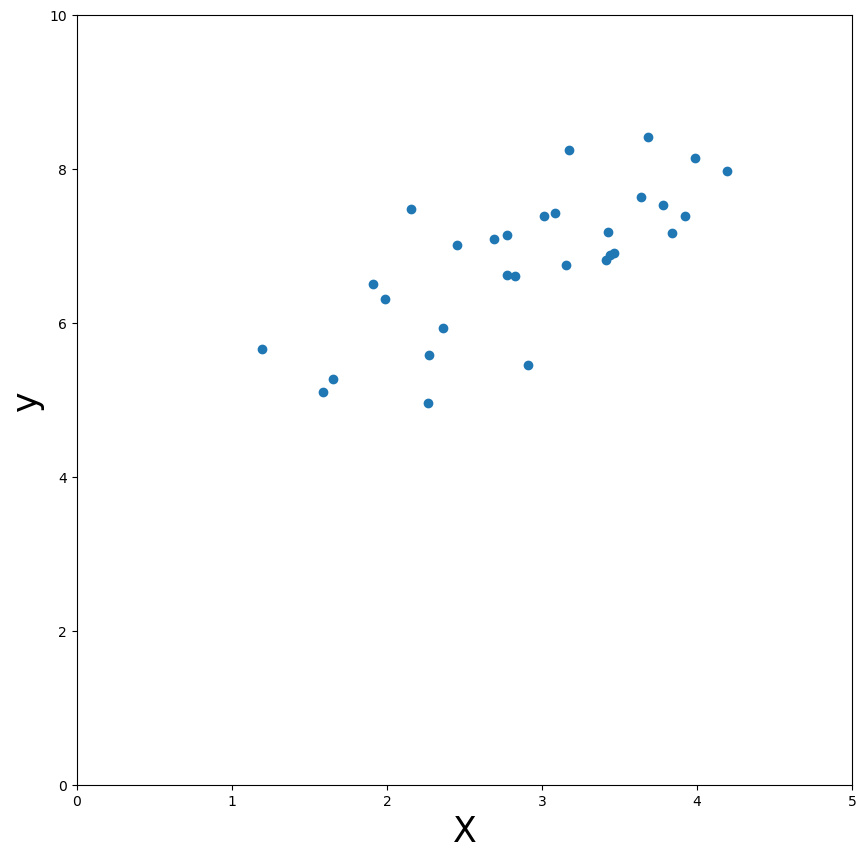

In [8]:
plt.figure(figsize=(10, 10))
plt.scatter(X_with_icept[:, 1], y)
plt.xlabel('X', fontsize=25)
plt.ylabel('y', fontsize=25)
plt.xlim((0, 5))
plt.ylim((0, 10))
plt.show()

### Parameters in linear regression
As you can see, there seems to be some positive linear relationship between $X$ (just the independent variable without the intercept) and $y$. In other words, an increase in $X$ will lead to an increase in $y$. But, at this moment, *how much exactly* $y$ changes for a increase in $X$ is unknown. By doing a linear regression with $X$ as our predictor of $y$, we can quantify this! 

The parameter, i.e. the "thing" that quantifies the influence of $X$ on $y$, calculated by this model is often called the **beta-parameter(s)** (but sometimes they're denoted as theta, or any other greek symbol/letter). The beta-parameter quantifies exactly how much $y$ changes if you increase $X$ by 1. Or, in other words, it quantifies how much influence $X$ has on $y$. In a formula ($\delta$ stands for "change in")\*: 

\begin{align}
\beta_{j} = \frac{\delta y}{\delta X_{j}} 
\end{align}

As you probably realize, each predictor in $X$ (i.e., $X_{j}$) has a parameter ($\beta_{j}$) that quantifies how much influence that predictor has on our target variable ($y$). This includes the intercept, our vector of ones (which is in textbooks often denoted by $\beta_{0}$; they often don't write out $\beta_{0}X_{0}$ because, if a vector of ones is used, $\beta_{0}\cdot 1$ simplifies to $\beta_{0}$).

Thus, linear regression describes a model in which a set of beta-parameters are calculated to characterize the influence of each predictor in $X$ on $y$, that together explain $y$ as well as possible (but the model is usually not perfect, so there will be some *error*, or "unexplained variance", denoted by $\epsilon$). As such, we can formulate the linear regression model as follows:

\begin{align}
y = \beta_{0} + X_{1}\beta_{1} + X_{2}\beta_{2} ... + X_{P}\beta_{P} + \epsilon
\end{align}

which is often written out as (and is equivalent to the formula above):

\begin{align}
y = \sum_{j=1}^{P}X_{j}\beta_{j} + \epsilon
\end{align}

Here, $\epsilon$ is the variance of $y$ that cannot be explained by our predictors (i.e, the *error*). 

But how does linear regression estimate the beta-parameters? The method most often used is called **'ordinary least squares'** (OLS; or just 'least squares'). This method tries to find a "weight(s)" for the independent variable(s) such that when you multiply the weight(s) with the independent variable(s), it produces an estimate of $y$ (often denoted as $\hat{y}$, or "y-hat") that is as 'close' to the true $y$ as possible. In other words, least squares tries to 'choose' the beta-parameter(s) ($\hat{\beta}$) such that the difference between $X$ multiplied with the beta(s) (i.e. our best guess of $y$, denoted as $\hat{y}$) and the true $y$ is minimized\*. 

Let's just formalize this formula for the 'best estimate of $y$' (i.e. $\hat{y}$):

\begin{align}
\hat{y}_{i} = \sum_{j=1}^{P}X_{ij}\hat{\beta}_{j} 
\end{align}

Before we're going into the estimation of these beta-parameters, let's practice with calculating $\hat{y}$!

<div class='alert alert-warning'>
    <b>ToDo</b> (1 point): Below, we've defined a design matrix with two predictors (<tt>this_X</tt>) and an array with beta-estimates (<tt>these_betas</tt>; just pretend that these betas were estimated by us beforehand). Now, given this data, can you calculate the predicted $y$-values (i.e., $\hat{y}$)? Store these predicted $y$-values in an array named <tt>this_y_hat</tt>.

Hint: your <tt>this_y_hat</tt> array should be of shape <tt>(100,)</tt>.
</div>

In [9]:
# Just generate some random normal data with mean 0, std 1, and shape 100x2 (NxP)
this_X = np.random.normal(0, 1, (100, 2))
these_betas = np.array([5, 3])

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [10]:
''' Tests the above ToDo'''
from niedu.tests.nii.week_2 import test_X_times_betas
test_X_times_betas(this_X, these_betas, this_y_hat)

NameError: name 'this_y_hat' is not defined

### Refresher: matrix multiplication
In the GLM (and statistics in general), you'll very likely come across concepts and operations from linear (matrix) algebra, such as matrix multiplication and the matrix inverse. In week 1, we briefly discussed how matrix/vector multiplication can be done with Python/numpy: using the `.dot` numpy attribute or with the `@` operator. In this course, you'll encounter several matrix operations as part of the GLM. In fact, we can implement the operation from the previous ToDo (calculating $\hat{y}$) using matrix multiplication as well.

See the figure below for a visual explanation of matrix multiplication:
![dot_prod](https://hadrienj.github.io/assets/images/2.2/dot-product.png)
*Image by Hadrien Jean ([link](https://hadrienj.github.io/assets/images/2.2/dot-product.png))*

If your understanding of matrix algebra, and especially matrix multiplication, is still somewhat rusty, check out [this video](https://www.youtube.com/watch?v=fkZj8QoYjq8) by Jeanette Mumford. Now, suppose that the left matrix in the above figure represents our matrix $\mathbf{X}$ and that the right vector represents our estimated parameters $\hat{\beta}$. Now, we can calculate $\hat{y}$ as the matrix operator $X\hat{\beta}$:

\begin{align}
\hat{y} = 
  \begin{bmatrix}
    X_{1,1} & X_{1,2} \\
    X_{2, 1} & X_{2, 2} \\
    \vdots & \vdots \\
    X_{N, 1} & X_{N, 2}
  \end{bmatrix} 
  \begin{bmatrix}
    \hat{\beta}_{1} \\
    \hat{\beta}_{2}
  \end{bmatrix}
\end{align}

Let's check this in code:

In [11]:
this_y_hat_dot = this_X @ these_betas  # this_X.dot(these_betas) is also correct
print(this_y_hat_dot)

[ -0.01338524   1.6703706    2.21587559  10.21759739   6.73838803
  -8.73396662   3.42869211  -4.48842891   0.95290386   3.43650722
  -1.71391492   2.1629619    1.34852454  -2.22062007   3.99755808
   6.55005865  -3.79261597   2.34949198  -1.58847781  -1.00590812
   1.43788029   3.79819378  -4.96641193   0.84168045  -1.23324889
  -5.92010843   1.65225542  -2.18412034  -5.04079461   6.83379015
  -2.44856964  12.2700849   -5.58141723   9.15228886  -3.40630421
  -2.71636339  -4.49867819   2.09344214  -0.83014248   4.14900705
  -1.23808648   6.5956657    3.06043025   2.24424643   3.21012702
  -8.85509716  11.75506195   1.90635652  -1.03938628  -3.27900914
  -5.57655277   0.35407235   1.95194714   5.57227764   5.26441588
  -0.53012277  11.8957242   -0.46059776   5.79536197   2.4409444
  -5.42215061   6.39560171  -2.40432132   3.53601676   1.18398727
   6.910171    12.85646364  -1.58706604   4.27244301   7.18808465
   0.4676259    3.05310707 -11.94182401 -10.92527308   0.27265972
  -5.660524

In other words, the non-matrix algebra notation ...

\begin{align}
\hat{y}_{i} = \sum_{j=1}^{P}X_{ij}\hat{\beta}_{j} 
\end{align}

... is exactly the same as the the following matrix algebra notation:

\begin{align}
\hat{y}_{i} = \mathbf{X}_{i}\mathbf{\hat{\beta}} 
\end{align}

You can usually recognize the implementations in formulas using algebra by the use of bold variables (such as $\mathbf{X}$, which denote matrices) here above.

*You will calculate `y_hat` quite a lot throughout this lab; please use the matrix algebra method to calculate `y_hat`, because this will likely prevent errors in the future!* So, use this ...

```python
y_hat = X @ betas
```

instead of ...

```python
y_hat = X[:, 0] * betas[0] + X[:, 1] * betas[1]
```

### Fitting OLS models
Thus far, we've ignored how OLS actually calculates (or "fits") the unknown parameters $\beta$. Roughly speaking, OLS finds parameters that minimize the *sum of squared errors* (hence the name '[ordinary] least squares'!):

\begin{align}
\min_{\beta} \sum_{i=1}^{N}(y_{i} - X_{i}\hat{\beta})^2 
\end{align}

This formula basically formalizes the approach of OLS "find the beta(s) that minimize the difference of my prediction of $y$ (calculated as $X \cdot \beta$) and the true $y$". Now, this still begs the question, *how does OLS estimate these parameters?* It turns out there is an "analytical solution" to this problem, i.e., there is a way to compute beta estimates that are guaranteed (given some assumptions) to give the parameters that minimize the summed squared error. This solution involves a little matrix algebra and is usually formulated as a series of matrix operations:

\begin{align}
\hat{\beta} = (\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}y
\end{align}

(For the mathematically inclined, see [this](https://economictheoryblog.com/2015/02/19/ols_estimator/) or [this](https://socialstatisticsfun.wordpress.com/2012/12/18/deriving-the-ols-estimator-continued/) blog for the derivation of the OLS solution.) In this formula, $\mathbf{X}^{T}$ refers to the transpose of the design matrix $\mathbf{X}$.

We don't expect you to understand every aspect of this formula, but you should understand the objective of least squares (minimizing the difference between $\hat{y}$ and true $y$) and what role the beta-parameters play in this process (i.e. a kind of weighting factor of the predictors).

Let's look at how we'd implement the OLS solution in code. We'll use the `@` operator for matrix multiplication and the `inv` function from the `numpy.linalg` module for the matrix inversion (i.e., the $(X^{T}X)^{-1}$ part).

In [12]:
from numpy.linalg import inv

est_betas = inv(X_with_icept.T @ X_with_icept) @ X_with_icept.T @ y

print("Shape of estimated betas: %s" % (est_betas.shape,))
print(est_betas)

Shape of estimated betas: (2, 1)
[[4.25897963]
 [0.88186203]]


"What? Why are there two beta-parameters?", you might think. This is of course because you also use the intercept as a predictor, which also has an associated beta-value (weighting factor). Here, the first beta refers to the intercept of the model (because it's the first column in the design-matrix)! The second beta refers to our 'original' predictor. Thus, the model found by least squares for our generated data is (i.e. that leads to our best estimate of $y$, i.e. $\hat{y}$:

\begin{align}
\hat{y} = X_{1} \cdot 4.259 + X_{2} \cdot 0.882 
\end{align}

And since our intercept (here $X_{1}$) is a vector of ones, the formula simplifies to:

\begin{align}
\hat{y} = 4.259 + X_{2} \cdot 0.882
\end{align}

Now, let's calculate our predicted value of $y$ ($\hat{y}$) by implementing the above formula by multiplying our betas with the corresponding predictors (intercept and original predictor). Here, because we have two predictors, we simply add the two "`predictor * beta`" terms to get the final $\hat{y}$.

In [13]:
y_hat = X_with_icept[:, 0] * est_betas[0] + X_with_icept[:, 1] * est_betas[1]
print('The predicted y-values are: \n\n%r' % y_hat)

The predicted y-values are: 

array([5.7162258 , 7.64565627, 6.82238735, 5.65711982, 6.70719685,
       6.25586475, 7.2814034 , 6.26277124, 7.29362822, 6.70672011,
       7.50612402, 6.01015768, 6.3415733 , 7.26833396, 6.98078313,
       7.59385684, 7.71516161, 7.46966721, 7.77394491, 5.30902899,
       7.31258926, 7.05767059, 7.03969805, 6.15914774, 6.63192082,
       6.75167254, 7.95782627, 6.91573708, 5.94300991, 6.41880247])


Now, let's plot the predicted $y$ values ($\hat{y}$) against the true $y$ values ($y$).

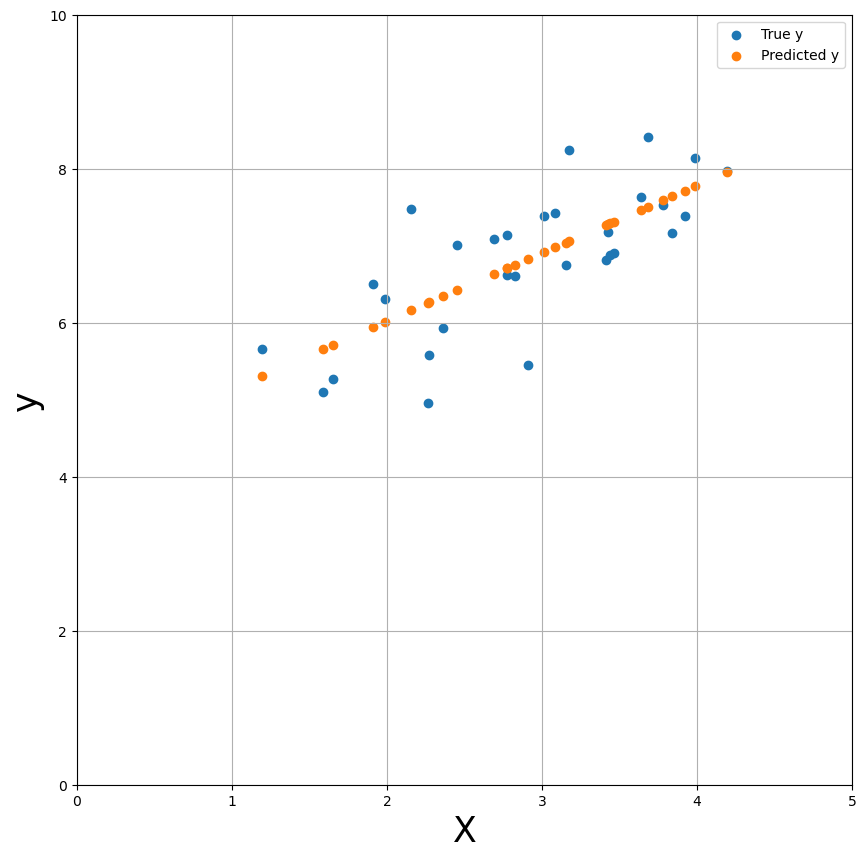

In [14]:
plt.figure(figsize=(10, 10))
plt.scatter(X, y)
plt.xlabel('X', fontsize=25)
plt.ylabel('y', fontsize=25)
x_lim = (0, 5)
plt.xlim(x_lim)
plt.ylim((0, 10))
y_hat = X_with_icept @ est_betas # using the matrix algebra approach!
plt.scatter(X, y_hat, c='tab:orange')
plt.legend(['True y', 'Predicted y'])
plt.grid()
plt.show()

Actually, let's just plot the predicted y-values as a line (effectively interpolating between adjacent predictions) - this gives us the linear regression plot as you've probably seen many times in your statistics classes!

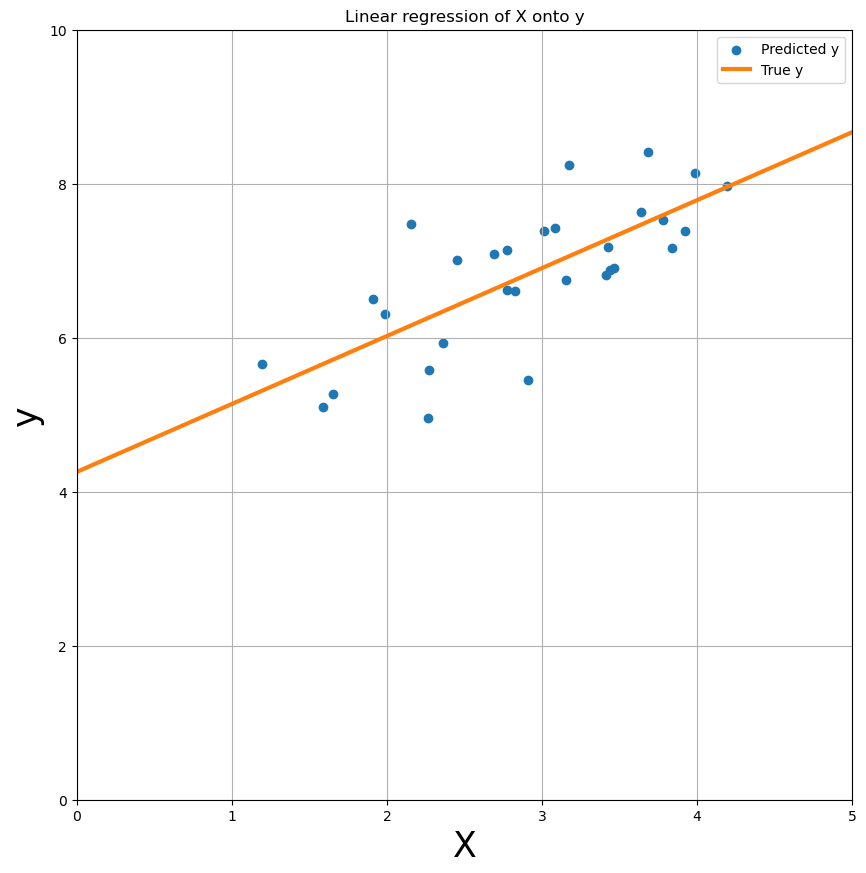

In [15]:
plt.figure(figsize=(10, 10))
plt.scatter(X, y)
plt.xlabel('X', fontsize=25)
plt.ylabel('y', fontsize=25)
plt.xlim(x_lim)
plt.ylim((0, 10))
y_min_pred = est_betas[0] + est_betas[1] * x_lim[0]
y_max_pred = est_betas[0] + est_betas[1] * x_lim[1]
plt.plot(x_lim, [y_min_pred, y_max_pred], ls='-', c='tab:orange', lw=3)
plt.legend(['Predicted y', 'True y'])
plt.title('Linear regression of X onto y')
plt.grid()
plt.show()

### Residuals and model fit
Alright, so now we have established the beta-values that lead to the best prediction of $y$ - in other words, the best fit of our model. But how do we quantify the fit of our model? One way is to look at the difference between $\hat{y}$ and y, which is often referred to as the model's **residuals**. This difference between $\hat{y}$ and $y$ - the residuals - is the exact same thing as the $\epsilon$ in the linear regression model, i.e. the **error** of the model. Thus, for a particular dependent variable $y$, the residuals ($\epsilon$) of a particular fitted model with parameters $\hat{\beta}$ are computed as: 

\begin{align}
\epsilon = y - \mathbf{X}\hat{\beta} 
\end{align}

To visualize the residuals (plotted as red dashed lines):

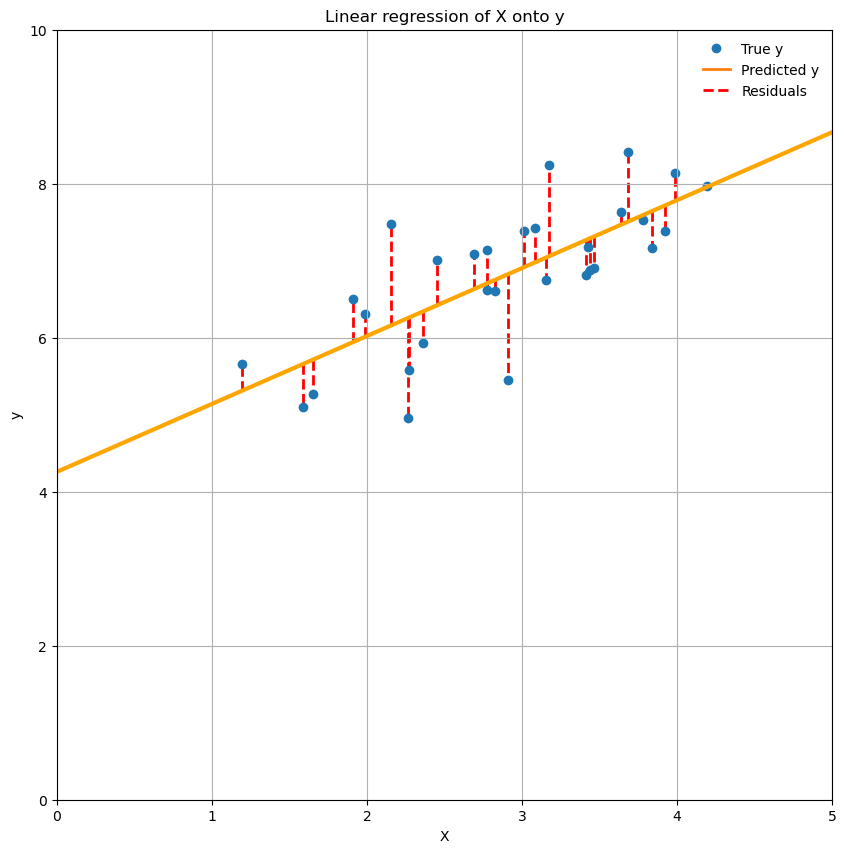

In [16]:
plt.figure(figsize=(10, 10))
plt.scatter(X, y)
plt.xlabel('X')
plt.ylabel('y')
plt.xlim(x_lim)
plt.ylim((0, 10))
y_min_pred = est_betas[0] + est_betas[1] * x_lim[0]
y_max_pred = est_betas[0] + est_betas[1] * x_lim[1]
plt.plot(x_lim, [y_min_pred, y_max_pred], ls='-', c='orange', lw=3)
plt.title('Linear regression of X onto y')

for i in range(y.size):
    plt.plot((X[i], X[i]), (y_hat[i], y[i]), linestyle='--', c='red', lw=2, zorder=0)


from matplotlib.lines import Line2D
custom_lines = [
    Line2D([0], [0], color='tab:blue', marker='o', ls='None', lw=2),
    Line2D([0], [0], color='tab:orange', lw=2),
    Line2D([0], [0], color='r', ls='--', lw=2)
]

plt.legend(custom_lines, ['True y', 'Predicted y', 'Residuals'], frameon=False)
plt.grid()
plt.show()

In fact, the model fit is often summarized as the **mean of the squared residuals** (also called the 'mean squared error' or MSE), which is thus simply the (length of the) red lines squared and averaged. In other words, the MSE refers to the average squared difference between our predicted $y$ and the true $y$\*:

\begin{align}
\mathrm{MSE} = \frac{1}{N}\sum_{i=1}^{N} (y_{i} - \hat{y}_{i})^2
\end{align}

\* The "$\frac{1}{N}\sum_{i=1}^{N}$" is just a different (but equally correct) way of writing "the average of all residuals from sample 1 to sample N".

<div class='alert alert-warning'>
    <b>ToDo</b> (1 point): Calculate the MSE for our previous model predictions (<tt>y_hat</tt>) based on our linear regression model predicting <tt>y</tt> from <tt>X_with_intercept</tt>. <em>Do not use a for-loop for this.</em> You know how to do this without a loop, using vectorized numpy array operations. Store the result in a variable named <tt>mse</tt>.
</div>

In [17]:
# Implement your ToDo here
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [18]:
''' Tests the above ToDo. '''
from niedu.tests.nii.week_2 import test_mse_calculation
test_mse_calculation(mse, y, y_hat)

NameError: name 'mse' is not defined

Another metric for model fit in linear regression is "R-squared" ($R²$). R-squared is calculated as follows:

\begin{align}
R^2 = 1 - \frac{\sum_{i=1}^{N}(y_{i} - \hat{y}_{i})^2}{\sum_{i=1}^{N}(y_{i} - \bar{y})^2}
\end{align}

where $\bar{y}$ represents the mean of $y$. As you can see, the formula for R-squared consists of two parts: the numerator ($\sum_{i=1}^{N}(y_{i} - \hat{y}_{i})^2$) and the denominator ($\sum_{i=1}^{N}(y_{i} - \bar{y}_{i})^2$). The denominator represents the *total* amount of squared error of the actual values ($y$) relative to the mean ($\bar{y}$). The numerator represents the *reduced* squared errors when incorporating knowledge from our (weighted) independent variables ($X_{i}\hat{\beta}$). So, in a way you can interpret R-squared as *how much better my model is including `X` versus a model that only uses the mean*. Another conventional interpretation of R-squared is the proportion of variance our predictors ($X$) together can explain of our target ($y$).

As expected, the code is quite straightforward:

In [19]:
numerator = np.sum((y - y_hat) ** 2)  # remember, y_hat equals X * beta
denominator = np.sum((y - np.mean(y)) ** 2)
r_squared = 1 - numerator / denominator

print('The R² value is: %.3f' % r_squared)

The R² value is: 0.549


<div class='alert alert-warning'>
    <b>ToDo</b> (1 point): Below, we've defined a design matrix (<tt>X_test</tt>, including an intercept) and a dependent variable (<tt>y_test</tt>). Run a linear regression model and calculate R-squared. Store the R-squared value (which should be a single number, a float) in a variable named <tt>r_squared_test</tt>.
</div>

In [20]:
data_tmp = np.load('data_todo_rsquared.npz')
X_test, y_test = data_tmp['X'], data_tmp['y']

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [21]:
''' Tests the above ToDo '''
from niedu.tests.nii.week_2 import test_rsquared_todo
test_rsquared_todo(X_test, y_test, r_squared_test)    

NameError: name 'r_squared_test' is not defined

<div class='alert alert-info'>
<b>ToThink</b> (1 point): As discussed earlier, it's important to model the intercept in regression models. This is because it often greatly <em>improves model fit</em>! In this ToThink, you have to explain <em>why</em> modelling the intercept (usually) improves model fit. 

To give you some clues, we re-did the linear regression computation from above, but now without the intercept in the design matrix. We plotted the data (<tt>X_no_icept</tt>, <tt>y</tt>) and the model fit to get some intuition about the use of an intercept in models. 

In the text-cell below the plot, explain (concisely!) why modelling the intercept (usually) improves model fit (this is manually graded, so no test-cell).
</div>

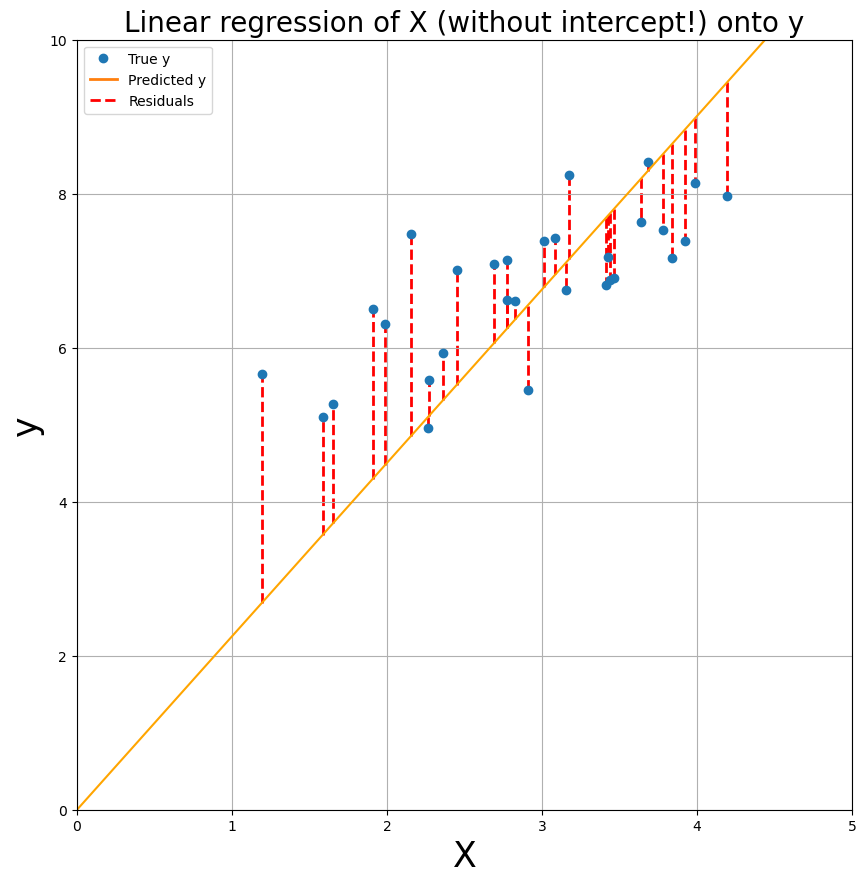

In [22]:
X_no_icept = X_with_icept[:, 1, np.newaxis]
beta_no_icept = inv(X_no_icept.T @ X_no_icept) @ X_no_icept.T @ y
y_hat_no_icept = beta_no_icept * X_no_icept

plt.figure(figsize=(10, 10))
plt.scatter(X, y, zorder=2)
plt.xlabel('X', fontsize=25)
plt.ylabel('y', fontsize=25)
plt.xlim((0, 5))
plt.ylim((0, 10))
y_min_pred = beta_no_icept[0] * x_lim[0]
y_max_pred = beta_no_icept[0] * x_lim[1]
plt.plot(x_lim, [y_min_pred, y_max_pred], ls='-', c='orange')
plt.grid()
plt.title('Linear regression of X (without intercept!) onto y', fontsize=20)

for i in range(y.size):
    plt.plot((X[i], X[i]), (y_hat_no_icept[i], y[i]), 'r--', lw=2, zorder=1)

plt.legend(custom_lines, ['True y', 'Predicted y', 'Residuals'])
plt.show()

YOUR ANSWER HERE

### Summary: linear regression
Alright, hopefully this short recap on linear regression has refreshed your knowledge and understanding of important concepts such as predictors/design matrix ($X$), target ($y$), least squares, beta-parameters, intercept, $\hat{y}$, residuals, MSE, and $R^2$. 

In sum, for a linear regression analysis you need some predictors ($X$) to model some target ($y$). You perform ordinary least squares to find the beta-parameters that minimize the sum of squared residuals. To assess model fit, you can look at the mean squared error (average mis-prediction) or $R^2$ (total explained variance).

If you understand the above sentence, you're good to go! Before we go on to the real interesting stuff (modelling fMRI data with linear regression), let's test how well you understand linear regression so far.

<div class='alert alert-warning'>
<b>ToDo</b> (2 points):
    
Now, you're going to implement your own linear regression on a new set of variables, but with a twist: you're going to use 5 predictors this time - we've generated the data for you already. You'll notice that the code isn't much different from when you'd implement linear regression for just a single predictor (+ intercept). In the end, you should have calculated MSE and $R^2$, which should be stored in variables named <tt>mse_todo</tt> and <tt>r2_todo</tt> respectively.

*Note, though, that it **isn't** possible to plot the data (either X, y, or y_hat) because we have more than one predictor now; X is 5-dimensional (6-dimensional if you include the intercept) - and it's impossible to plot data in 5 dimensions!*

To give you some handles on how to approach the problem, you can follow these steps:

1. Check the shape of your data: is the shape of X <tt>(N, P)</tt>? is the shape of y <tt>(N, 1)</tt>?
2. Add an intercept to the model, use: <tt>np.hstack</tt>;
3. Calculate the beta-parameters using the formula you learned about earlier;
4. Evaluate the model fit by calculating the MSE and R-squared;
</div>

In [23]:
# Here, we load the data
data = np.load('ToDo.npz')
X, y = data['X'], data['y']

In [24]:
# 1. Check the shape of X and y

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [25]:
# 2. Add the intercept (perhaps define N first, so that your code will be more clear?) using np.hstack()

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [26]:
# 3. Calculate the betas using the formula you know

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [27]:
# 4. Calculate the MSE (store it in a variable named mse_todo)

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [28]:
# 5. Calculate R-squared  (store it in a variable named r2_todo)

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [29]:
''' Tests the ToDo above, MSE part. '''
np.testing.assert_almost_equal(mse_todo, 0.656, decimal=3)
print("Well done!")

NameError: name 'mse_todo' is not defined

In [30]:
''' Tests the ToDo above, R2-part part. '''
np.testing.assert_almost_equal(r2_todo, 0.3409, decimal=4)
print("Well done!")

NameError: name 'r2_todo' is not defined

<div class='alert alert-info'>
<b>ToThink</b> (1 point): Let's check whether you understand what a particular beta-parameter means.

- Some of the betas are negative (i.e., $\hat{\beta}< 0$); what does this tell you about the effect of that particular condition/predictor? (.5 point; first text-cell)
- The intercept-parameter (i.e., $\beta_{0}$) should be about 6.6. What does this value tell us about the signal?

Write your answers in the two text-cells below.
</div>

YOUR ANSWER HERE

YOUR ANSWER HERE

If you've finished the ToDo exercise and you're confident that you understand linear regression, you're ready to start with the fun part: applying the GLM to fMRI data!

## GLM in fMRI analyses
Univariate fMRI analyses basically use the same linear regression model as we've explained above to model the activation of voxels (with some minor additions) based on some design-matrix.

### The target
However, compared to "regular" data, one major difference is that *the dependent variable ($y$) in fMRI analyses is timeseries data*, which means that the observations of the dependent variable (activation of voxels) vary across time. 

How does such a time-series data look? Let's look at a (simulated) time-series from a single voxel:

In [31]:
# import some stuff if you haven't done that already
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
%matplotlib inline

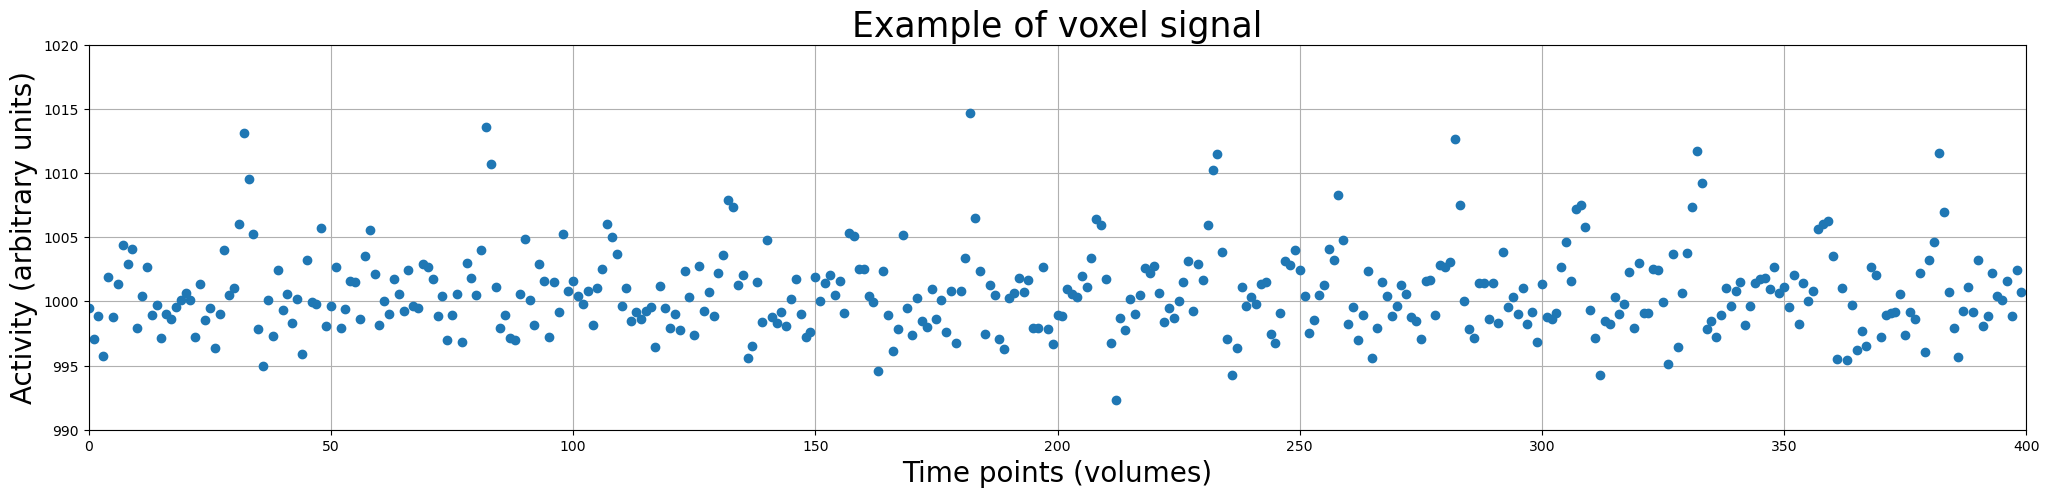

In [32]:
voxel_signal = np.load('example_voxel_signal.npy')
plt.figure(figsize=(25, 5))
plt.plot(voxel_signal, 'o')
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
x_lim, y_lim = (0, 400), (990, 1020)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.title('Example of voxel signal', fontsize=25)
plt.grid()
plt.show()

So, the voxel timeseries (i.e. activation over time; often called 'signal') is our dependent variable ($y$). Thus, the different time points (with corresponding activity values) make up our observations/samples!

<div class='alert alert-info'>
<b>ToThink</b> (0 points): Suppose that the TR ("time to repetition", i.e. how long it takes to measure each volume) of our acquisition was 2 seconds, can you deduce the duration of the experiment (in seconds) from the plot above? (Not graded, so you don't have to write anything down!)
</div>

So, in the plot above, the data points represent the activity (in arbitrary units) of a single voxel across time (measured in volumes). This visualization of the time-series data as discrete measurements is not really intuitive. Usually, we plot the data as continuous line over time (but always remember: fMRI data is a discretely sampled signal -- *not* a continuous one). Let's plot it as a line:

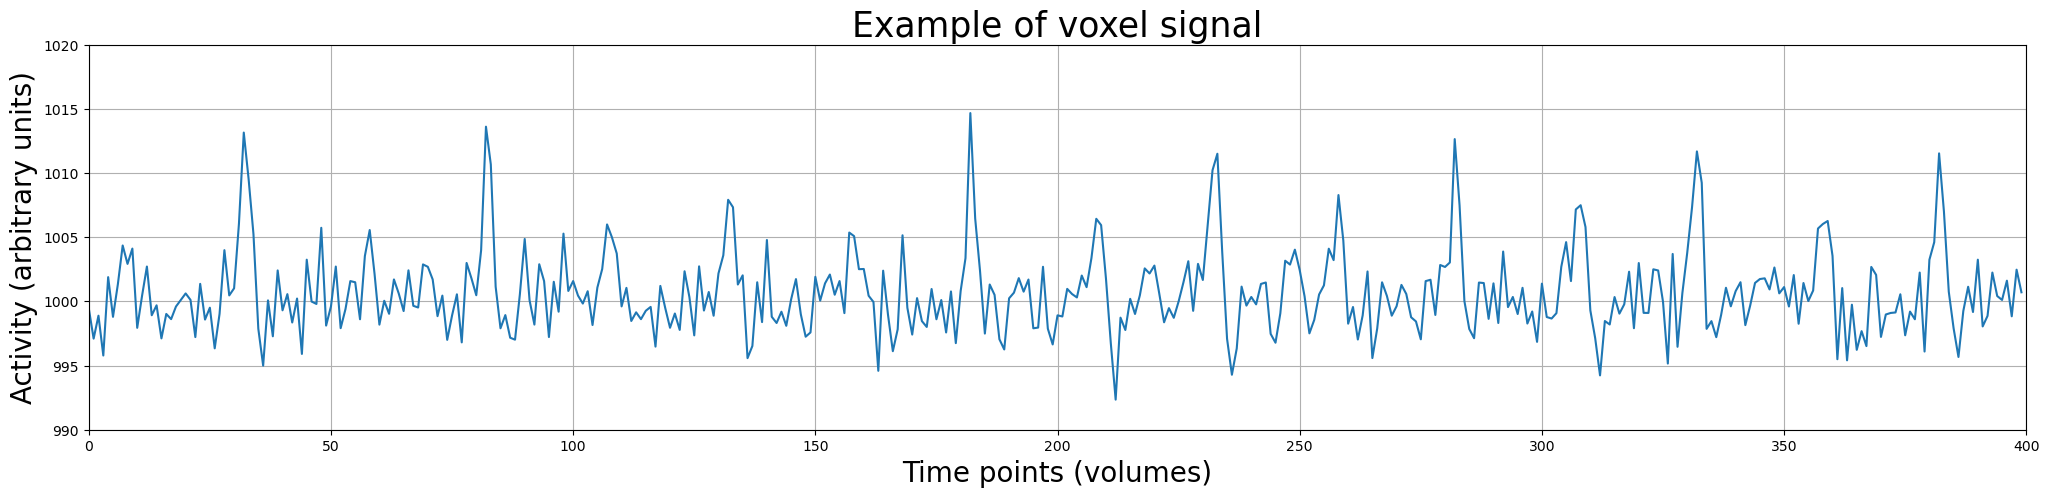

In [89]:
plt.figure(figsize=(25, 5))
plt.plot(voxel_signal)
plt.xlabel('Time points (volumes)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.title('Example of voxel signal', fontsize=25)
plt.grid()
plt.show()

Alright, this looks better. Now, let's look at our potential predictors ($X$).

### The predictors, or: what should we use to model our target?

#### Defining independent variables

So, we know what our target is (the time-series data), but what do we use to model/explain our signal? Well, in most neuroimaging research, your predictors are defined by your experimental design! In other words, your predictors consist of *whatever you think influenced your signal*. 

In neuroimaging research, we often derive our predictors from properties of the particular experiment that we use in the MRI-scanner (or during EEG/MEG acquisiton, for that matter). In other words, we can use any property of the experiment that we believe explains our signal.

Alright, probably still sounds vague. Let's imagine a (hypothetical) experiment in which we show subjects images of either circles or squares during fMRI acquisition lasting 800 seconds, as depicted in the image below:

![img](https://docs.google.com/drawings/d/e/2PACX-1vQwC4chpnzsDEzKhrKH_WHhMX7vJswY4H0pkyIxdlxI_I2GG5e8i6lsiWUO0SUk7NBgdV-vXD5PIleJ/pub?w=950&h=397)

Note that the interstimulus interval (ISI, i.e., the time between consecutive stimuli) of 50 seconds, here, is quite unrealistic; often, fMRI experiments have a much shorter ISI (e.g., around 3 seconds). Here, we will use an hypothetical experiment with an ISI of 50 seconds because that simplifies things a bit and will make figures easier to interpret.

Anyway, let's talk about what predictors we could use given our experimental paradigm. One straighforward suggestion about properties that influence our signal is that our signal is influenced by the stimuli we show the participant during the experiment. As such, we could construct a predictor that predicts some response in the signal when a stimulus (here: a square or a circle) is present, and no response when a stimulus is absent.

Fortunately, we kept track of the onsets (in seconds!) of our stimuli during the experiment:

In [34]:
onsets_squares = np.array([10, 110, 210, 310, 410, 510, 610, 710], dtype=int)
onsets_circles = np.array([60, 160, 260, 360, 460, 560, 660, 760], dtype=int)

In other words, the first circle-stimulus was presented at 60 seconds after the scan started and the last square-stimulus was presented 710 seconds after the can started.

For now, we'll ignore the difference between square-stimuli and circle-stimuli by creating a predictor that lumps the onsets of these two types of stimuli together in one array. This predictor thus reflects the hypothesis that the signal is affected by the presence of a stimulus (regardless of whether this was a square or a circle). (Later in the tutorial, we'll explain how to *compare* the effects of different conditions.)

We'll call this predictor simply `onsets_all`:

In [35]:
onsets_all = np.concatenate((onsets_squares, onsets_circles))
print(onsets_all)

[ 10 110 210 310 410 510 610 710  60 160 260 360 460 560 660 760]


Now, we need to do one last thing: convert the `onsets_all` vector into a proper predictor. Right now, the variable contains only the onsets, but a predictor should be an array with the same shape as the target.

Given that our predictor should represent the hypothesis that the signal responds to the presence of a stimulus (and doesn't respond when a stimulus is absent), we can construct our predictor as a vector of all zeros, except at indices corresponding to the onsets of our stimuli, where the value is 1.

We do this below:

In [36]:
predictor_all = np.zeros(800)  # because the experiment lasted 800 seconds
predictor_all[onsets_all] = 1  # set the predictor at the indices to 1

print("Shape of predictor: %s" % (predictor_all.shape,))
print("\nContents of our predictor array:\n%r" % predictor_all.T)

Shape of predictor: (800,)

Contents of our predictor array:
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 

We can even plot it in a similar way as we did with the voxel signal:

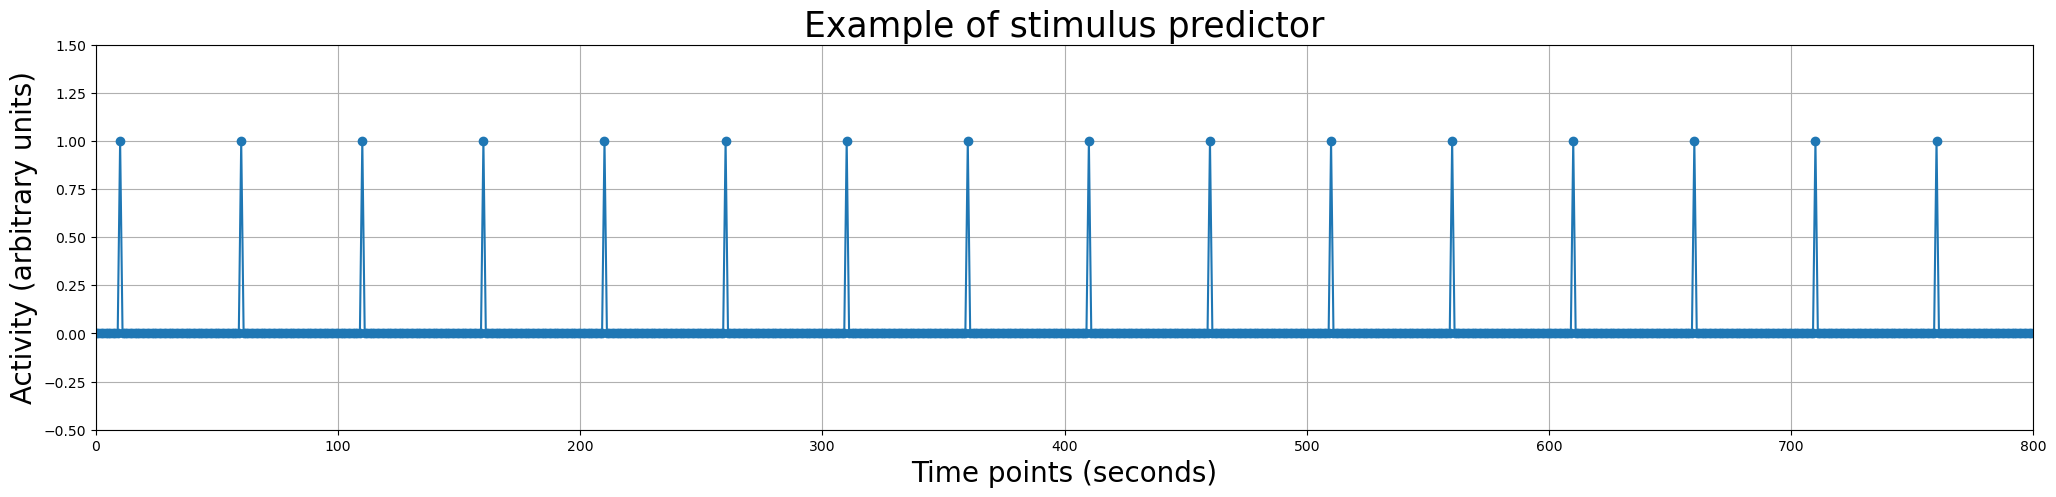

In [37]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all, marker='o')
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 800)
plt.ylim(-.5, 1.5)
plt.title('Example of stimulus predictor', fontsize=25)
plt.grid()
plt.show()

#### Resampling
However, if you look back at the plot of the voxel signal, you might notice that there is a problem in our stimulus-predictor - it seems to be on a different timescale than the signal. And that's true! The signal from the voxel is measured in volumes (in total 400, with a TR of 2 seconds) while the stimulus-onsets are defined in seconds (ranging from 10 to 760)!

This "issue" can be solved by downsampling our predictor to the time resolution of our signal, i.e., one datapoint every two seconds (given that our TR is 2 seconds). In the plot below, we show you with dashed red lines which datapoints would constitute our predictor *after* downsampling (we only show the first 100 seconds for clarity).

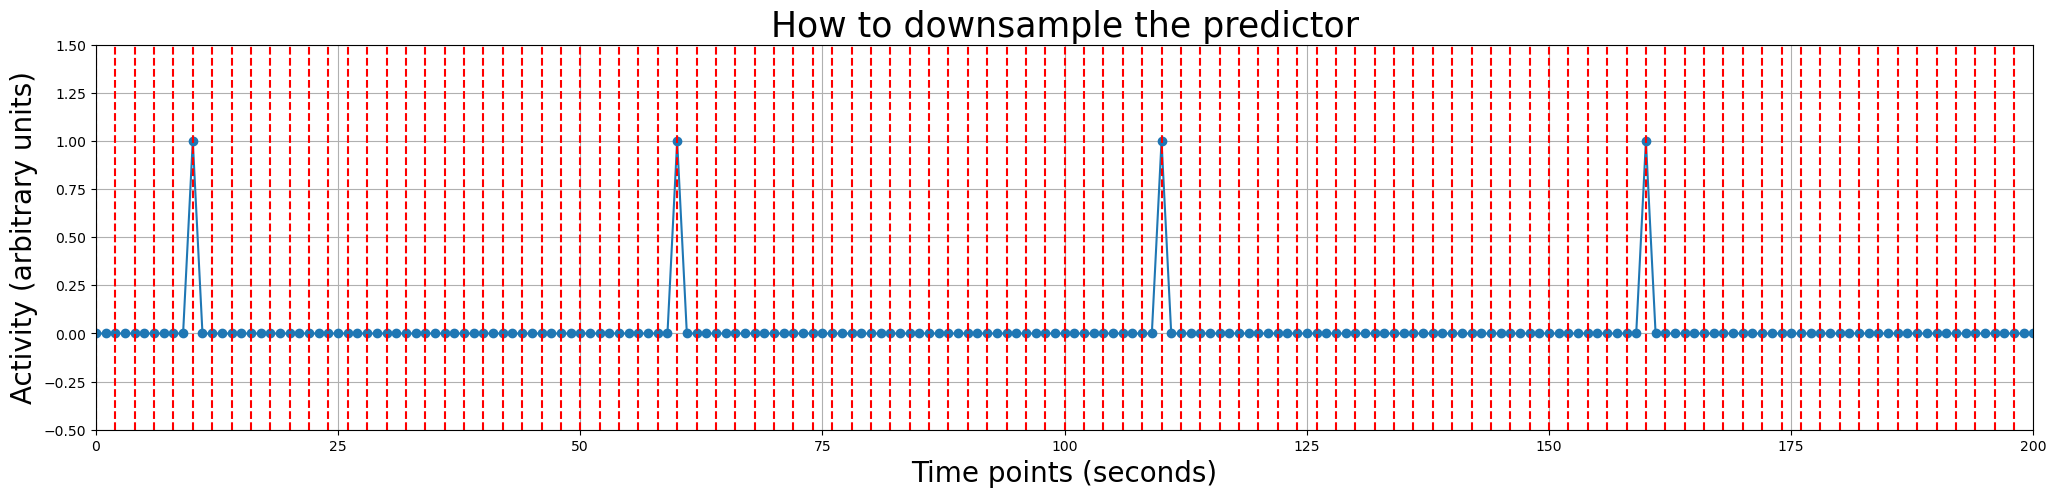

In [38]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all, marker='o')
plt.xlabel('Time points (seconds)', fontsize=20)
plt.ylabel('Activity (arbitrary units)', fontsize=20)
plt.xlim(0, 200)
plt.ylim(-.5, 1.5)
plt.title('How to downsample the predictor', fontsize=25)
plt.grid()

for t in np.arange(0, 200, 2):
    plt.axvline(t, ls='--', c='r')

plt.show()

Resampling in Python can be done using the `interp1d` function from the `scipy.interpolate` package. It works by first creating a mapping between the *scale* of the original array and the *values* of the original array, and then converting the original array to a *different scale*. We'll show you how this would be done with our `predictor_all` array. 

```python
resampler = interp1d(original_scale, original_array, kind='linear')  # interp1d returns a (new) function
downsampled_array = resampler(desired_scale) 
```

Note that when creating the mapping by calling `interp1d`, the function returns a *new function*, which we store in a variable called `resampler`. Now, we can call with new function with our desired scale for our array, which will result the original array downsampled at the desired scale (note that this works exactly the same for *up*sampling). Also note that we we use specifically "linear" resampling (by using `kind='linear'`). In practice, most neuroimaging packages use non-linear resampling/interpolation when downsampling predictors, but the details of different kinds of resampling are beyond the scope of this course. 

Anyway, let's try this on our predictor by resampling it from the original scale (0-800 seconds) to the scale of our signal (i.e., at 0, 2, 4, 8 ... 800 seconds, assuming a TR of 2 seconds). Note the function `np.arange`, which can be used to create evenly spaced arrays (with `np.arange(start, stop, step)`):

In [39]:
from scipy.interpolate import interp1d
original_scale = np.arange(0, 800, 1)  # from 0 to 800 seconds
print("Original scale has %i datapoints (0-800, in seconds)" % original_scale.size)
resampler = interp1d(original_scale, predictor_all)

desired_scale = np.arange(0, 800, 2)
print("Desired scale has %i datapoints (0, 2, 4, ... 800, in volumes)" % desired_scale.size)
predictor_all_ds = resampler(desired_scale)

print("Downsampled predictor has %i datapoints (in volumes)" % predictor_all_ds.size)

Original scale has 800 datapoints (0-800, in seconds)
Desired scale has 400 datapoints (0, 2, 4, ... 800, in volumes)
Downsampled predictor has 400 datapoints (in volumes)


That seemed to have worked! Let's print it to be sure:

In [40]:
print(predictor_all_ds)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

Awesome! Now, we have a predictor ($X$) and a target ($y$) of the same shape, so we can apply linear regression! But before we do this, let's plot the predictor and the signal in the same plot:

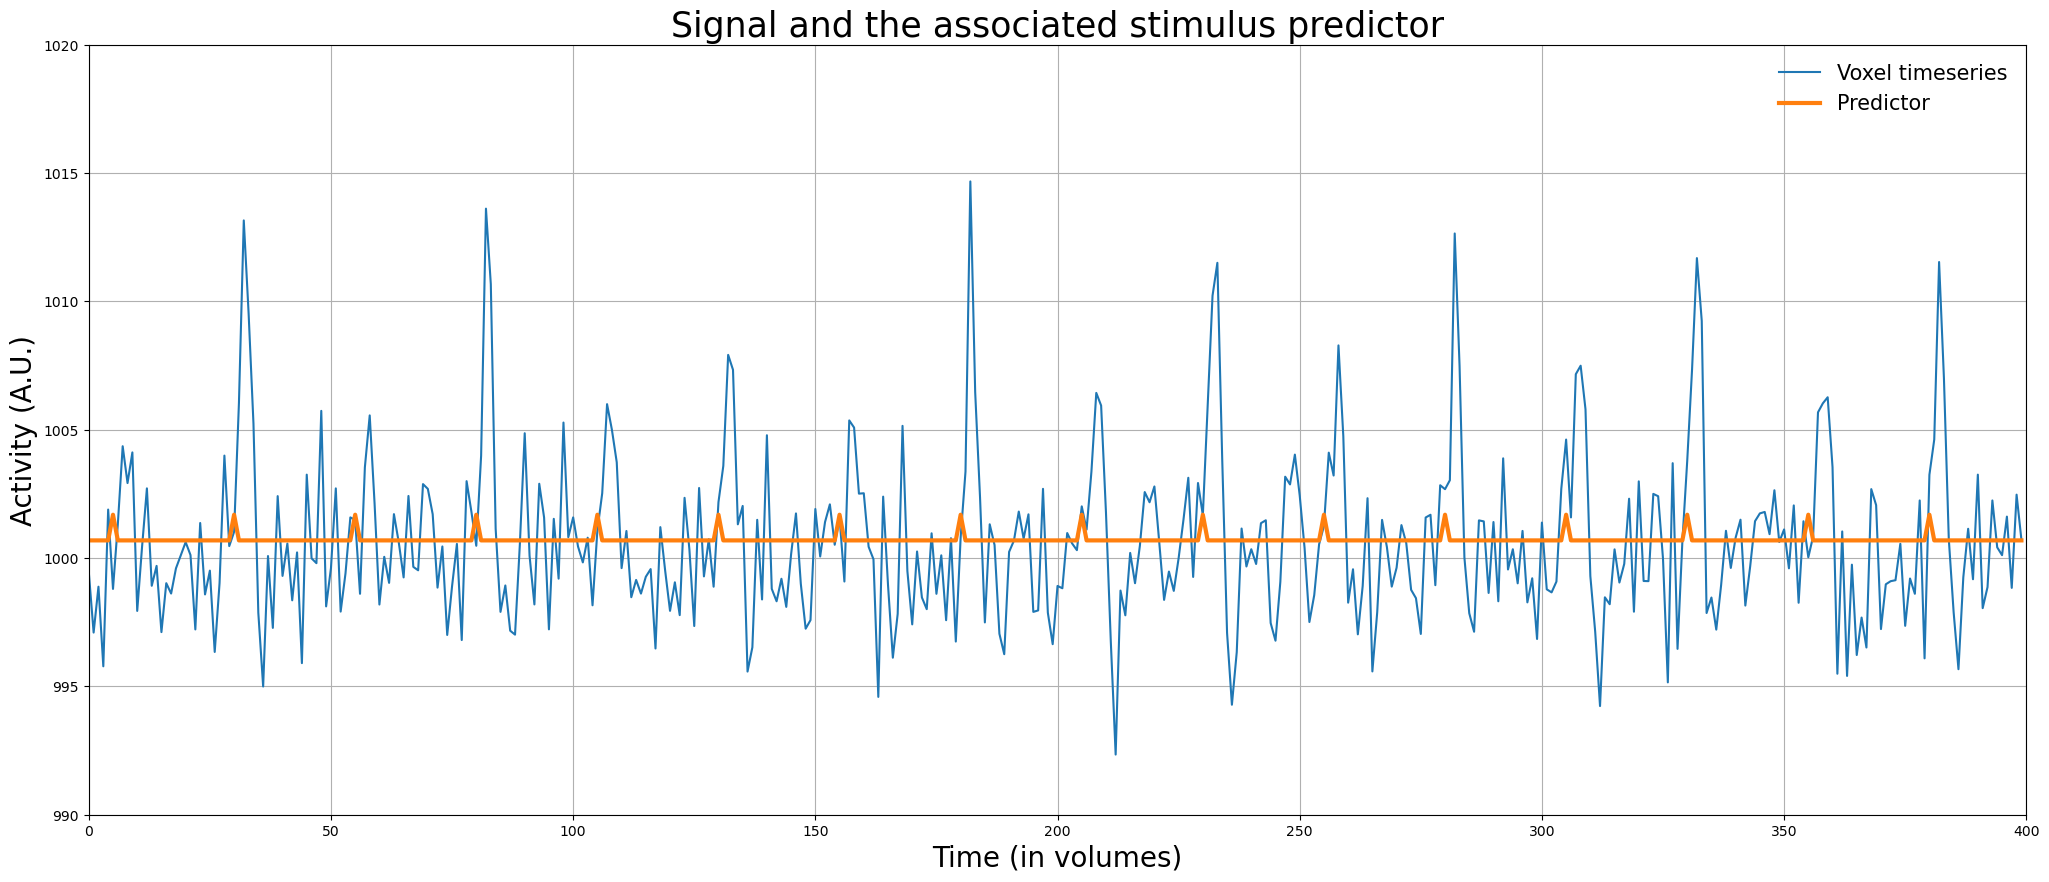

In [41]:
plt.figure(figsize=(25, 10))
plt.plot(voxel_signal)
plt.plot(predictor_all_ds + voxel_signal.mean(), lw=3)
plt.xlim(x_lim)
plt.ylim(y_lim)
plt.xlabel('Time (in volumes)', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.legend(['Voxel timeseries', 'Predictor'], fontsize=15, loc='upper right', frameon=False)
plt.title("Signal and the associated stimulus predictor", fontsize=25)
plt.grid()
plt.show()

Often, the design matrix is actually specified with higher precision (e.g., on the scale of milliseconds) than we did in the previous example (i.e., seconds) to accomodate onsets that are not "locked" to full seconds (e.g., $t=10$, $t=60$, but never $t=10.296$). We'll come back to this issue later in the tutorial.

But first, let's practice!

<div class='alert alert-warning'><b>ToDo</b> (2 points): Below, we've defined an array of onsets (<tt>onsets2</tt>) belonging to a hypothetical experiment with a duration of 60 seconds and a TR of 3. Create a predictor at the timescale of seconds (should have a length of 60) and name this <tt>pred2</tt>. Then, downsample the predictor to the scale of the experiment (i.e., resample the predictor to the timepoints $t=0, t=3, t=6, t=9, ... , t=57$). Store this downsampled predictor in a variable named <tt>pred2_ds</tt>.
</div>

In [42]:
# Implement your ToDo Here
onsets2 = np.array([12, 24, 33, 42], dtype=int)

# First create pred2


# Then downsample it to create pred2_ds


# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [43]:
""" Tests the previous ToDo (part 1)"""
try:
    assert(pred2.size == 60)
except AssertionError as e:
    print("pred2 is not the right size!")
    raise(e)

try:
    np.testing.assert_array_equal(pred2[onsets2], np.ones(4))
except AssertionError as e:
    print("Predictor did not contains 1s at the indices corresponding to the onsets!")
    raise(e)
    
print("Well done! (test 1 / 2)")

NameError: name 'pred2' is not defined

In [44]:
""" Tests the previous ToDo (part 2)"""
try:
    np.testing.assert_array_equal(pred2_ds, pred2[::3])
except AssertionError as e:
    print("Something went wrong with downsampling ...")
    raise(e)
else:
    print("Well done! (test 2 / 2)")

NameError: name 'pred2_ds' is not defined

At this moment, we have everything that we need to run linear regression: a predictor (independent variable) and a signal (target/dependent variable) at the same scale and the same number of data points! This regression analysis allows us to answer the question whether the activity of the signal is significantly different when a stimulus is presented (i.e., at times when the predictor contains ones) than when no stimulus is presented (i.e., at times when the predictor contains zeros). 

Or, phrased differently (but mathematically equivalent): what is the effect of a unit increase in the predictor ($X = 0 = \mathrm{no\ stimulus} \rightarrow X = 1 = \mathrm{stimulus}$) on the target (the signal)? We will answer this question in the next section!

### Regression on fMRI data & interpretation parameters
As said before, applying regression analysis on fMRI data is done largely the same as on regular non-timeseries data. In the next ToDo, you're going to do exactly that.

<div class='alert alert-warning'>
    <b>ToDo</b> (2 points): We'll start by adding an intercept to <tt>predictor_all_ds</tt> for you, creating a new variable called <tt>X_simple</tt>. Now, run linear regression on the <tt>voxel_signal</tt> data and save the beta-parameters in a new variable named <tt>betas_simple</tt>. Finally, calculate MSE and $R^ 2$ for this model and store these values in new variables named <tt>mse_simple</tt> and <tt>r2_simple</tt>.
</div>

In [45]:
if predictor_all_ds.ndim == 1:  # do not remove this! This adds a singleton dimension, such that you can call np.hstack on it
    predictor_all_ds = predictor_all_ds[:, np.newaxis]

icept = np.ones((predictor_all_ds.size, 1))
X_simple = np.hstack((icept, predictor_all_ds))

# Start your ToDo here

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [46]:
''' Tests the above ToDo. '''
from niedu.tests.nii.week_2 import test_regression_signal_simple

if 'X_simple' not in dir():
    raise ValueError("Could not find a variable named 'X_simple'; did you name it correctly?")

if 'betas_simple' not in dir():
    raise ValueError("Could not find a variable named 'betas_simple'; did you name it correctly?")

if 'mse_simple' not in dir():
    raise ValueError("Could not find a variable named 'mse_simple'; did you name it correctly?")

if 'r2_simple' not in dir():
    raise ValueError("Could not find a variable named 'r2_simple'; did you name it correctly?")

test_regression_signal_simple(mse_simple, r2_simple, predictor_all_ds, voxel_signal)

ValueError: Could not find a variable named 'betas_simple'; did you name it correctly?

If you've done the ToDo correctly, you should have found the the following beta-parameters: 1000.657 for the intercept and 1.023 for our stimulus-predictor. This means that our linear regression model for that voxel is as follows:

\begin{align}
y_{voxel} = \beta_{intercept} + X_{stim}\beta_{stim} + \epsilon = 1000.647 + X_{stim}1.023 + \epsilon
\end{align}

This simply means that for a unit increase in $X$ (i.e., $X = 0 \rightarrow X = 1$), $y$ increases with 1.023. In other words, on average the signal is 1.023 higher when a stimulus is present compared to when a stimulus is absent!

To aid interpretation, let's plot the signal ($y$) and the predicted signal ($\hat{y} = \beta X$) in the same plot.

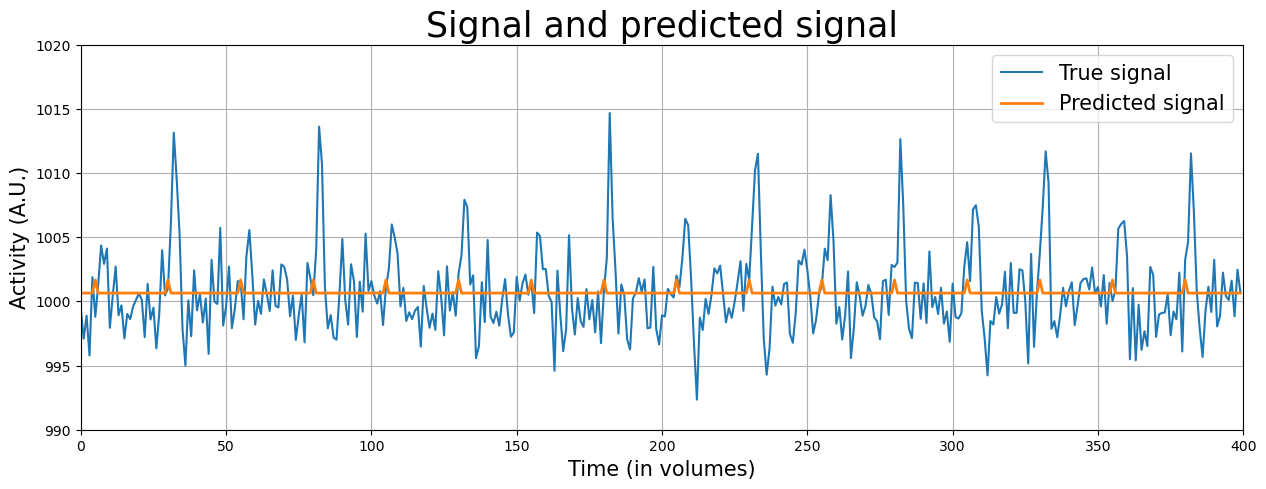

In [47]:
from niedu.utils.nii import plot_signal_and_predicted_signal 
# You may ignore the red text (a warning caused by some outdated code in some
# of the underlying packages we use)
plot_signal_and_predicted_signal(voxel_signal, predictor_all_ds, x_lim, y_lim)

The orange line represents the predicted signal, which is based on the original predictor ($X$) multiplied (or "scaled") by the associated beta-parameters ($\beta$). Graphically, you can interpret the beta-parameter of the stimulus-predictor ($\beta_{stim}$) as the maximum height of the peaks in the orange line\* and the beta-parameter of the intercept ($\beta_{intercept}$) as the difference from the flat portion of the orange line and 0 (i.e. the "offset" of the signal).

---
\* This holds true only when the maximum value of the original predictor is 1 (which is true in our case)

Let's zoom in on a portion of the data to show this:

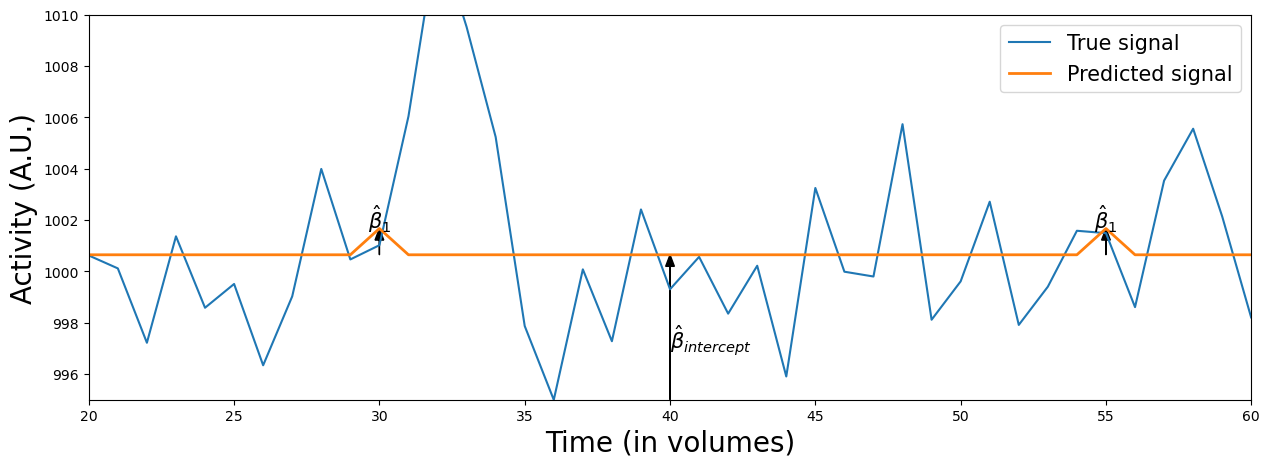

In [48]:
from niedu.utils.nii import plot_signal_and_predicted_signal_zoom
plot_signal_and_predicted_signal_zoom(voxel_signal, predictor_all_ds, x_lim=(20, 60), y_lim=(995, 1010))

Anyway, there seems to be an effect on voxel activity when we show a stimulus &mdash; an increase of 1.023 in the signal on average (about 0.1% percent signal change) &mdash; but you've also seen that the model fit is quite bad ($R^2 = 0.004$, about 0.4% explained variance) ...

What is happening here? Is our voxel just super noisy? Or is something wrong with our model? We'll talk about this in the next section!

### Using the BOLD response in GLM models
Let's go back to our original idea behind the predictor we created. We assumed that in order to model activity in response to our stimuli, our predictor should capture an increase/decrease in activity *at the moment of stimulus onset*. But this is, given our knowledge of the BOLD-response, kind of unrealistic to assume: it is impossible to measure instantaneous changes in neural activity in response to stimuli or tasks with fMRI, *because the BOLD-response is quite slow and usually peaks around 5-7 seconds **after** the 'true' neuronal activity (i.e. at cellular level)*. 

In the above model, we have not incorporated either the lag (i.e. ~6 seconds) or the shape of the BOLD-response: we simply modelled activity as an instantaneous response to a stimulus event. 

You can imagine that if you incorporate this knowledge about the BOLD-response into our model, the fit will likely get better! In this section, we'll investigate different ways to incorporate knowledge of the BOLD-response in our predictors.

#### The canonical HRF
The easiest and most often-used approach to incorporating knowledge about the BOLD-response in univariate analyses of fMRI data is to assume that each voxel responds to a stimulus in a fixed way. In other words, that voxels always respond (activate/deactivate) to a stimulus in the same manner. This is known as using a "canonical haemodynamic response function (HRF)". Basically, an HRF is a formalization of how we think the a voxel is going to respond to a stimulus. A *canonical* HRF is the implementation of an HRF in which you use the same HRF for each voxel, participant, and condition. There are other implementations of HRFs (apart from the canonical), in which you can adjust the exact shape of the HRF based on the data you have; examples of these HRFs are *temporal basis sets* and *finite impulse reponse models* (FIR), which we'll discuss later.

There are different types of (canonical) HRFs; each models the assumed shape of the BOLD-response slightly differently. For this course, we'll use the most often used canonical HRF: the double-gamma HRF, which is a combination of two different gamma functions (one modelling the overshoot and one modelling the post-stimulus undershoot).

We'll use the "double gamma" HRF implementation of the [nilearn](https://nilearn.github.io) Python package. They provide different "versions" of the HRF (which differ slightly in their shape); we'll use the "Glover" version, which is based on a double-[gamma function](https://en.wikipedia.org/wiki/Gamma_function): `glover_hrf`.

In [49]:
from nilearn.glm.first_level.hemodynamic_models import glover_hrf

This function takes a couple of arguments (the most important being: TR, oversampling factor, and length of the HRF in seconds), and returns a double gamma HRF. It is important to make sure that your HRF is on the same timescale as our design (predictors). In the previous section, we made sure we defined our predict at the time scale of seconds first before downsampling it to a time resolution of 2 seconds (i.e., the TR). 

Thus, given a TR of 2, we can use a "oversampling factor" of 2 to get the HRF on the timescale of seconds:

In [50]:
TR = 2
osf = 2
length_hrf = 32  # sec

canonical_hrf = glover_hrf(tr=TR, oversampling=osf, time_length=length_hrf, onset=0)
canonical_hrf /= canonical_hrf.max()
print("Size of canonical hrf variable: %i" % canonical_hrf.size)

Size of canonical hrf variable: 32


As you can see, the length of the `canonical_hrf` variable is 32 (seconds). Now, let's plot it:

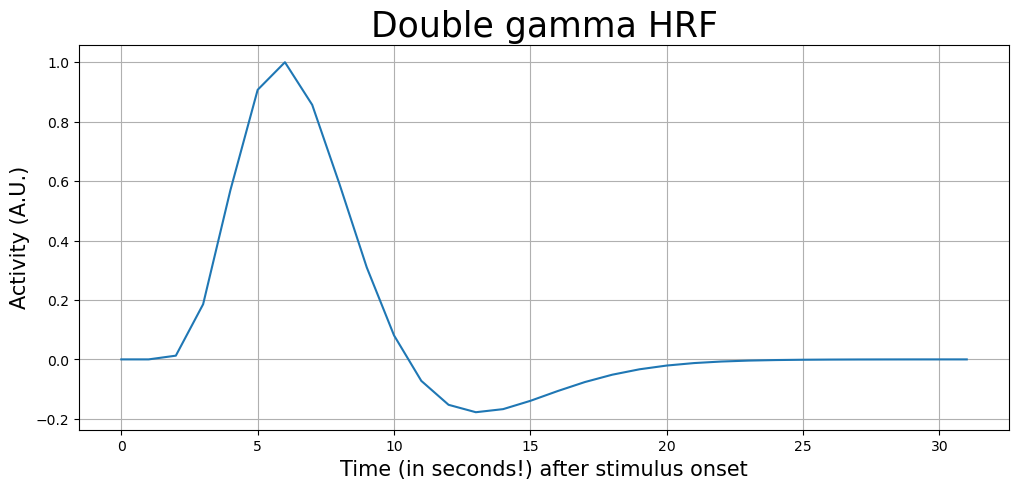

In [51]:
t = np.arange(0, canonical_hrf.size)

plt.figure(figsize=(12, 5))
plt.plot(t, canonical_hrf)
plt.xlabel('Time (in seconds!) after stimulus onset', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.title('Double gamma HRF', fontsize=25)
plt.grid()
plt.show()

#### Convolution
The figure of the HRF shows the expected idealized (noiseless) response to a single event. But how should we incorporate this HRF into our model? Traditionally, this is done using a mathematical operation called **convolution**. Basically, it "slides" the HRF across our 0-1 coded stimulus-vector from left to right and elementwise multiplies the HRF with the stimulus-vector. This is often denoted as:

\begin{align}
X_{\mathrm{conv}} = \mathrm{HRF} * X_{\mathrm{original}}
\end{align}

in which $*$ is the symbol for convolution, $X_{\mathrm{original}}$ is the original stimulus-vector, and $X_{\mathrm{conv}}$ the result of the convolution.

Let's plot an example to make it clearer. Suppose we have an onset-vector of length 100 (i.e., the experiment was 100 seconds long) with three stimulus presentations: at $t = 10$, $t = 40$, and $t = 70$. The stimulus-vector (upper plot), double-gamma HRF (right plot), and the result of the convolution of the stimulus-vector and the HRF (lower plot) looks as follows:

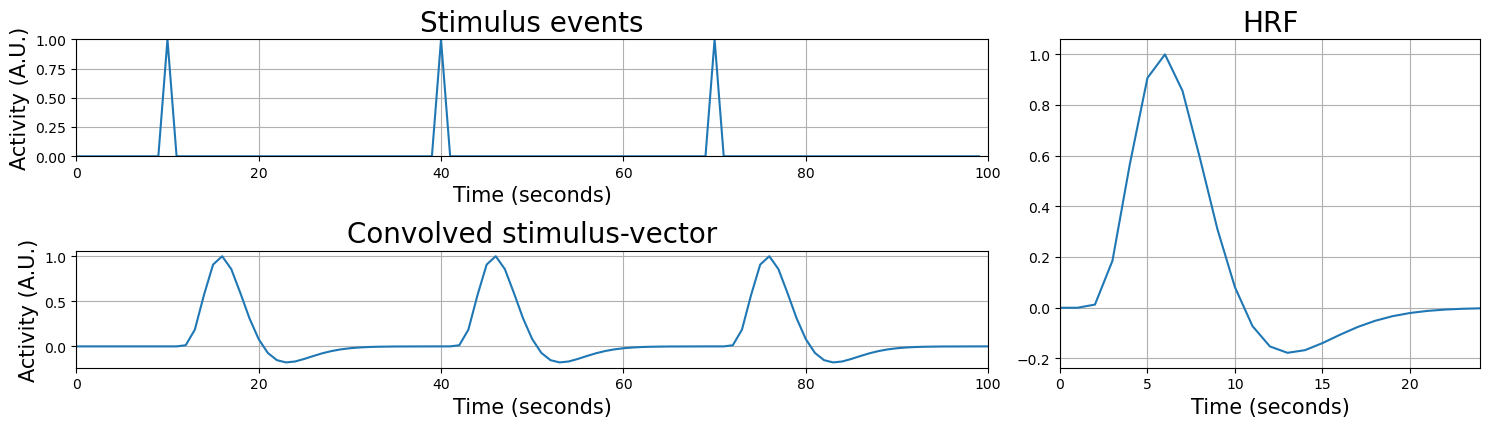

In [52]:
random_stimulus_onsets = [10, 40, 70]
random_stim_vector = np.zeros(100)
random_stim_vector[random_stimulus_onsets] = 1

plt.figure(figsize=(15, 6))
plt.subplot2grid((3, 3), (0, 0), colspan=2)
plt.plot(random_stim_vector)
plt.xlim((0, 100))
plt.ylim((0, 1))
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.title('Stimulus events', fontsize=20)
plt.grid()

plt.subplot2grid((3, 3), (0, 2), rowspan=2)
plt.plot(canonical_hrf)
plt.title('HRF', fontsize=20)
plt.xlim(0, 24)
plt.xlabel("Time (seconds)", fontsize=15)
plt.grid()

convolved_stim_vector = np.convolve(random_stim_vector, canonical_hrf, 'full')
plt.subplot2grid((3, 3), (1, 0), colspan=2)
plt.plot(convolved_stim_vector)
plt.title('Convolved stimulus-vector', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.xlim(0, 100)
plt.tight_layout()
plt.grid()
plt.show()

The result &mdash; the convolved stimulus-vector &mdash; is basically the output of a the multiplication of the HRF and the stimulus-events when you would "slide" the HRF across the stimulus vector. As you can see, the convolved stimulus-vector correctly shows the to-be-expected lag and shape of the BOLD-response! Given that this new predictor incorporates this knowledge of the to-be expected response, it will probably model the activity of our voxel way better. Note that the temporal resolution of your convolved regressor is necessary limited by the resolution of your data (i.e. the TR of your fMRI acquisition). That's why the convolved regressor doesn't look as "smooth" as the HRF. 

As you can see in the code for the plot above, numpy provides us with a function to convolve two arrays:

```python
np.convolve(array_1, array_2)
```

Now, we can convolve the HRF with out stimulus-predictor. Importantly, we want to do this convolution operation in the resolution of our onsets (here: seconds), not in the resolution of our signal (TR) (the reason for this is explained clearly in Jeanette Mumford's [video on the HRF](https://www.youtube.com/watch?v=5JNX34gYG7Q).)
Therefore, we need to perform the convolution on the variable `predictor_all` (*not* the downsampled variable: `predictor_all_ds`)!

We'll do this below (we'll reuse the `canonical_hrf` variable defined earlier):

In [53]:
'''We need to "squeeze" out the extra singleton axis, because that's
what the np.convolve function expects, i.e., arrays of shape (N,) and NOT (N, 1)
To go from (N, 1) --> (N,) we'll use the squeeze() method'''
predictor_conv = np.convolve(predictor_all.squeeze(), canonical_hrf)

print("The shape of the convolved predictor after convolution: %s" % (predictor_conv.shape,))

# After convolution, we also neem to "trim" off some excess values from
# the convolved signal (the reason for this is not important to understand)
predictor_conv = predictor_conv[:predictor_all.size]

print("After trimming, the shape is: %s" % (predictor_conv.shape,))

# And we have to add a new axis again to go from shape (N,) to (N, 1),
# which is important for stacking the intercept, later
predictor_conv = predictor_conv[:, np.newaxis]

print("Shape after adding the new axis: %s" % (predictor_conv.shape,))

The shape of the convolved predictor after convolution: (831,)
After trimming, the shape is: (800,)
Shape after adding the new axis: (800, 1)


It's a bit of a hassle (squeezing out the singleton axis, trimming, adding the axis back ...), but now we have a predictor which includes information about the expected HRF!

Let's look at the predictor before and after convolution in the same plot:

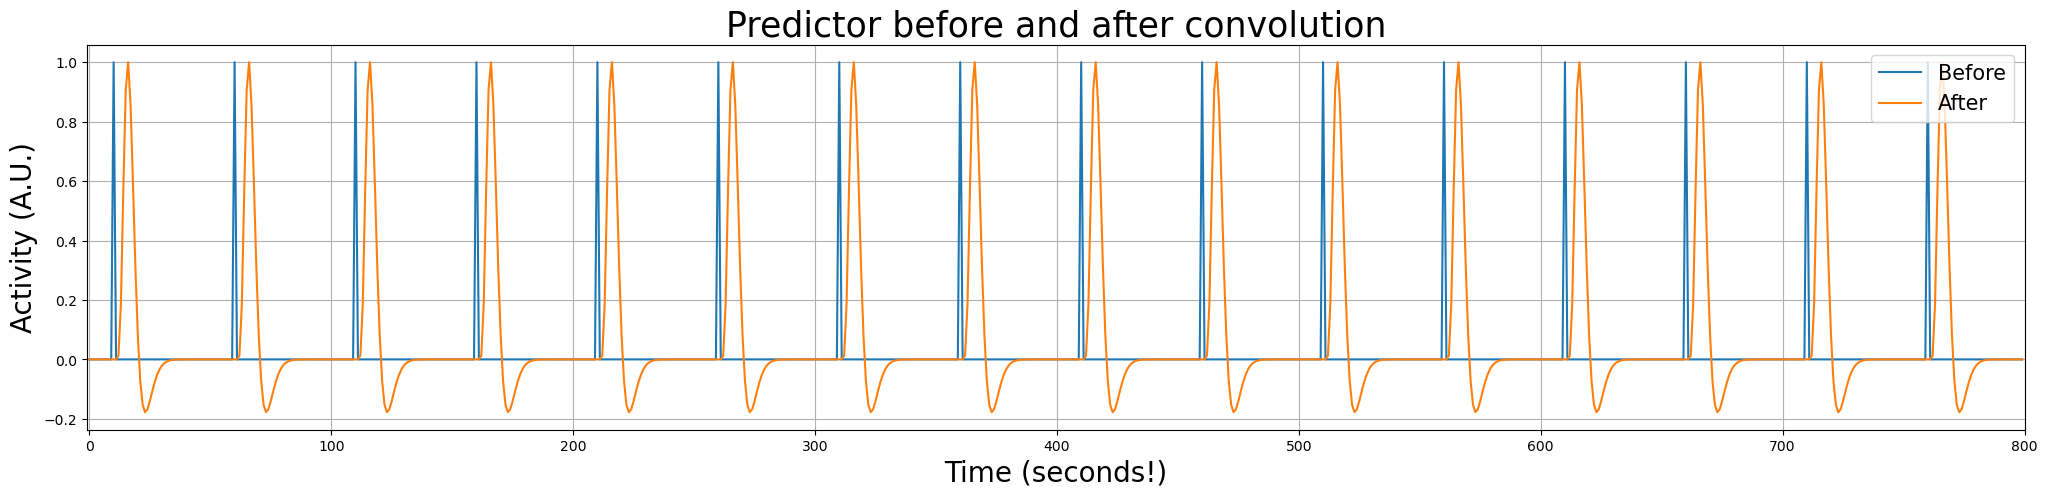

In [54]:
plt.figure(figsize=(25, 5))
plt.plot(predictor_all)
plt.plot(predictor_conv)
plt.xlim(-1, 800)
plt.title("Predictor before and after convolution", fontsize=25)
plt.xlabel("Time (seconds!)", fontsize=20)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.legend(['Before', 'After'], loc='upper right', fontsize=15)
plt.grid()
plt.show()

#### Linear scaling
Great! Our predictor now includes the expected 'lag' and shape of the HRF, and we can start analyzing our signal with our new convolved predictor! But before we'll do this, there is one more concept that we'll demonstrate. Remember the concept of **linear scaling** of the BOLD-response? This property of the BOLD-response states that it will linearly scale with the input it is given.

Let's see how that works:

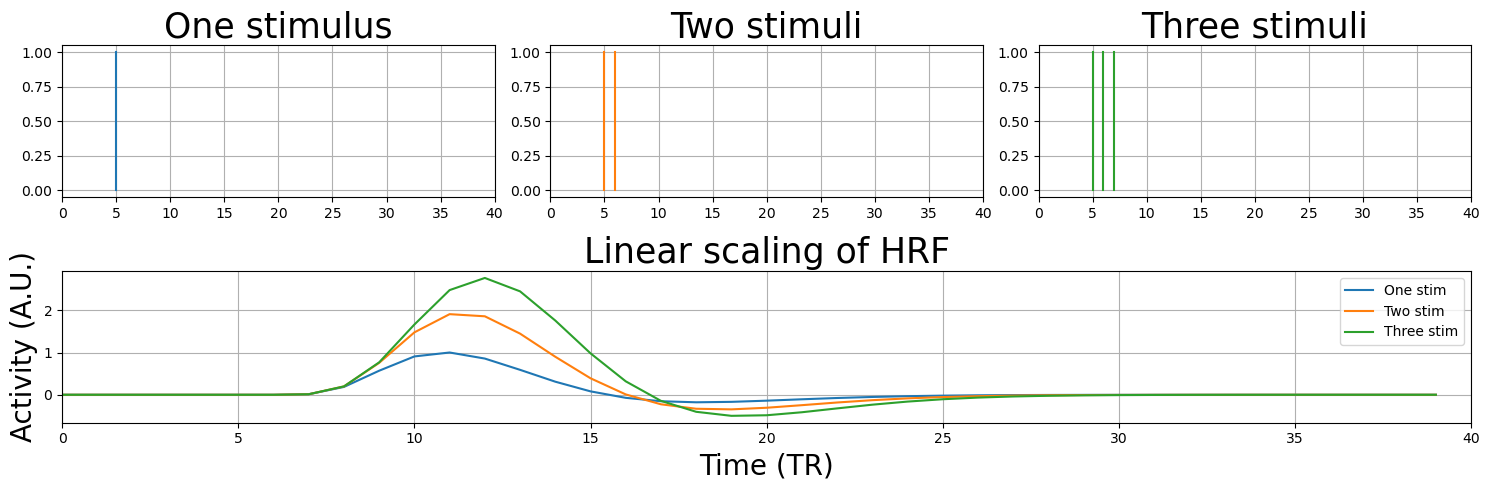

In [55]:
plt.figure(figsize=(15, 5))

N = 40
one_stim = np.zeros(N)
one_stim[5] = 1
one_stim_conv = np.convolve(one_stim, canonical_hrf)[:N]
two_stim = np.zeros(N)
two_stim[[5, 6]] = 1
two_stim_conv = np.convolve(two_stim, canonical_hrf)[:N]
three_stim = np.zeros(N)
three_stim[[5, 6, 7]] = 1
three_stim_conv = np.convolve(three_stim, canonical_hrf)[:N]

plt.subplot2grid((2, 3), (0, 0))
for ons in np.where(one_stim)[0]:
    plt.plot([ons, ons], [0, 1])

plt.xlim(0, N)
plt.title("One stimulus", fontsize=25)
plt.grid()

plt.subplot2grid((2, 3), (0, 1))
for ons in np.where(two_stim)[0]:
    plt.plot([ons, ons], [0, 1], c='tab:orange')

plt.xlim(0, N)
plt.title("Two stimuli", fontsize=25)
plt.grid()

plt.subplot2grid((2, 3), (0, 2))
for ons in np.where(three_stim)[0]:
    plt.plot([ons, ons], [0, 1], c='tab:green')

plt.xlim(0, N)    
plt.title("Three stimuli", fontsize=25)
plt.grid()

plt.subplot2grid((2, 3), (1, 0), colspan=3)
plt.plot(one_stim_conv)
plt.plot(two_stim_conv)
plt.plot(three_stim_conv)
plt.legend(['One stim', 'Two stim', 'Three stim'])
plt.title('Linear scaling of HRF', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (TR)', fontsize=20)
plt.xlim(0, N)
plt.grid()
plt.tight_layout()
plt.show()

Also, in our random stimulus-vector above (and also in the example we showed earlier) we assumed that each image was only showed briefly (i.e. we only modelled the onset) - but what if a stimulus (or task) may take longer, say, 15 seconds? Let's see what happens.

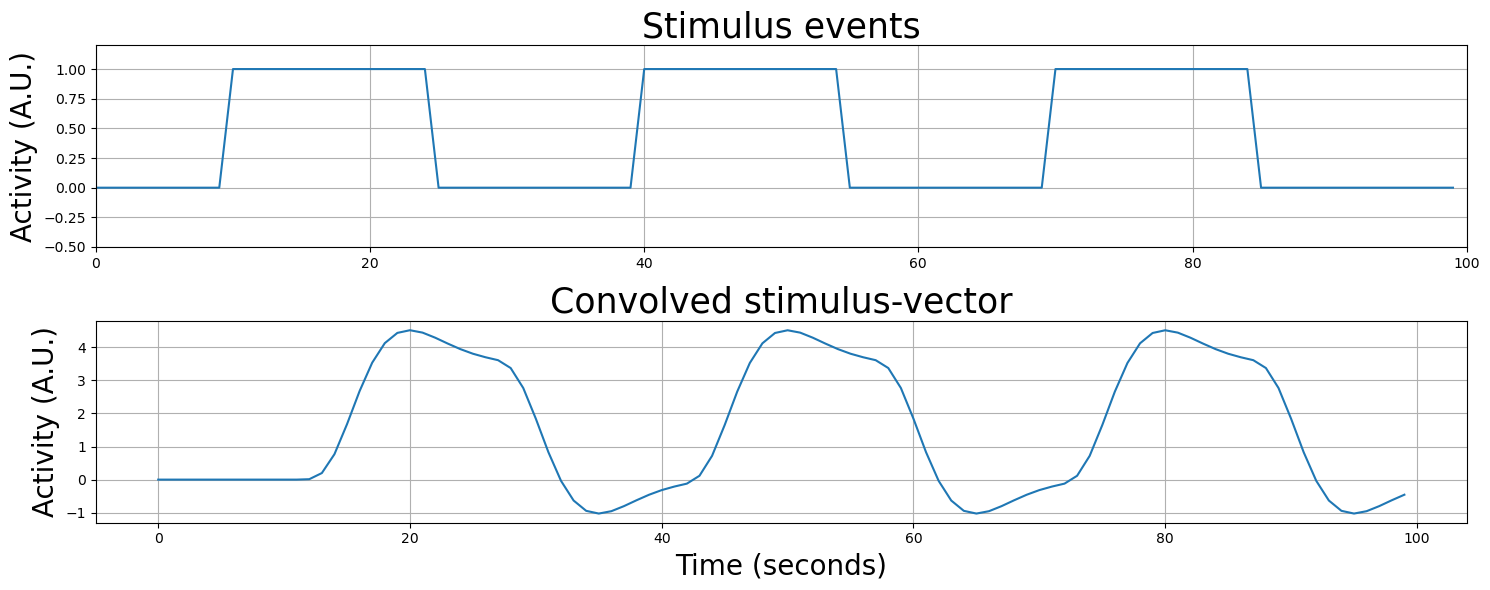

In [56]:
random_stimulus_onsets2 = list(range(10, 25)) + list(range(40, 55)) + list(range(70, 85))
random_stim_vector2 = np.zeros(100)

random_stim_vector2[random_stimulus_onsets2] = 1

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)
plt.grid()
plt.plot(random_stim_vector2, c='tab:blue')

plt.xlim((0, 100))
plt.ylim((-.5, 1.2))
plt.ylabel('Activity (A.U.)', fontsize=20)

plt.title('Stimulus events', fontsize=25)

convolved_stim_vector2 = np.convolve(random_stim_vector2, canonical_hrf)[:random_stim_vector2.size]
plt.subplot(2, 1, 2)
plt.plot(convolved_stim_vector2)
plt.title('Convolved stimulus-vector', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (seconds)', fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()

As you can see, convolution takes care to model the shape of the BOLD-response according to how long you specify the stimulus to take! 

<div class='alert alert-info'>
<b>ToThink</b> (1 point): Given the properties of the BOLD-response (and assuming linear-time invariance is not violated), would you expect the same or a different BOLD-response in response to 3 consecutive stimuli (of the same condition) of half a second second each (which follow each other immediately, i.e. without interstimulus interval) versus 1 stimulus of 1.5 seconds? Why? (Write your answer in the text-cell below)
</div>

YOUR ANSWER HERE

Actually, convolution can model *any* sequence of stimulus events, even stimuli with random onsets - just look at the plot below!

(you can execute this cell below multiple times to see different random regressor shapes!)

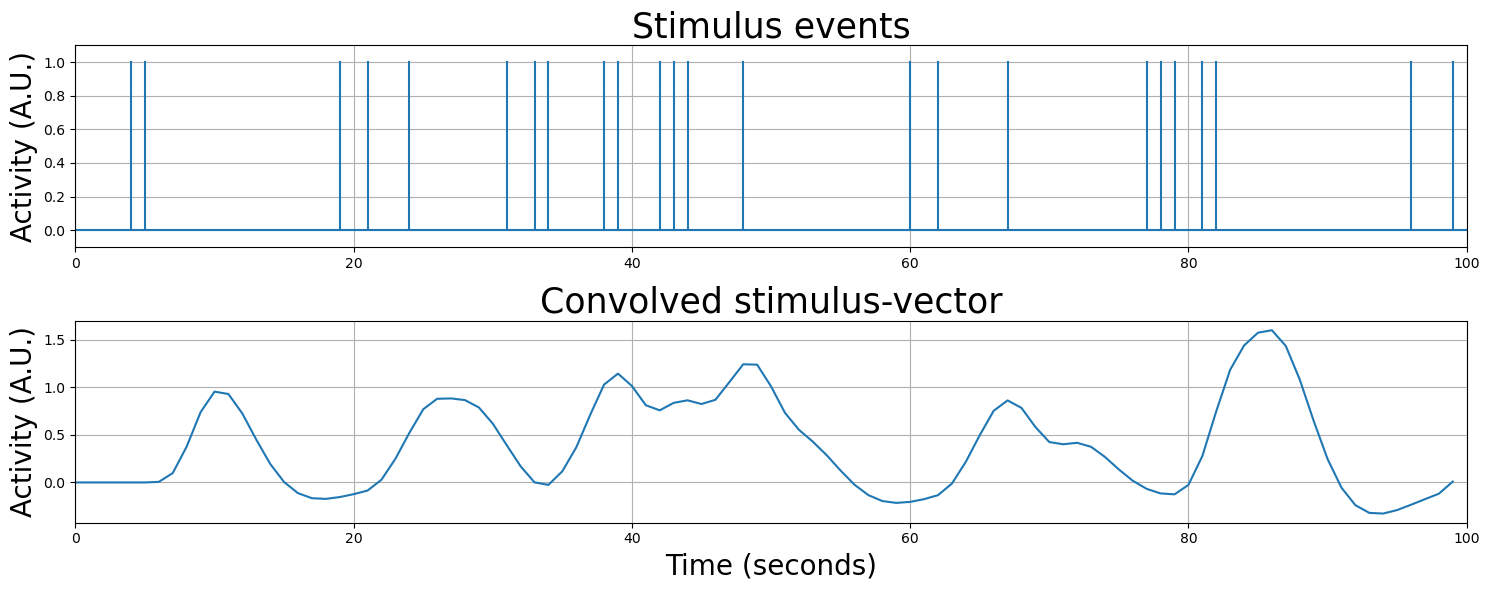

In [57]:
random_stimulus_onsets3 = np.random.randint(0, 100, 25)
random_stim_vector3 = np.zeros(100)
random_stim_vector3[random_stimulus_onsets3] = 1

plt.figure(figsize=(15, 6))
plt.subplot(2, 1, 1)

plt.axhline(0)
for i, event in enumerate(random_stim_vector3):
    if event != 0.0:
        plt.plot((i, i), (0, 1), '-', c='tab:blue')

plt.xlim((0, 100))
plt.ylim((-0.1, 1.1))
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.title('Stimulus events', fontsize=25)
plt.grid()

convolved_stim_vector3 = np.convolve(random_stim_vector3 * .5, canonical_hrf, 'full')[:random_stim_vector3.size]
plt.subplot(2, 1, 2)
plt.plot(convolved_stim_vector3)
plt.xlim(0, 100)
plt.title('Convolved stimulus-vector', fontsize=25)
plt.ylabel('Activity (A.U.)', fontsize=20)
plt.xlabel('Time (seconds)', fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()

<div class='alert alert-warning'>
    <b>ToDo</b> (1 point): Let's assume that we did an experiment in which participants were presented with a visual stimulus lasting 20 seconds six times over the course of an experiment of 3 minutes (starting at $t=0$, $t=30$, ... , $t=150$ sec). Create a stimulus predictor (on the timescale of seconds), store this in a variable named <tt>todo_pred</tt>, and then convolve this predictor with the <tt>canonical_hrf</tt> variable. Make sure to trim the convolved predictor, and store the result in a variable named <tt>todo_pred_conv</tt>.
</div>

In [58]:
# Implement your ToDo here

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [59]:
''' Tests the above ToDo'''
from niedu.tests.nii.week_2 import test_pred_conv

try:
    assert(todo_pred.size == 180)
except AssertionError as e:
    print("The predictor is not the right length!")
    raise(e)

try:
    assert(np.sum(todo_pred) == 120)
except AssertionError as e:
    print("Are you sure your stimulus events last 20 seconds?")
    raise(e)
    
try:
    assert(todo_pred_conv.size == 180)
except AssertionError as e:
    print("Did you trim the convolved predictor?")
    raise(e)

test_pred_conv(todo_pred_conv, canonical_hrf)
print("Well done!")

NameError: name 'todo_pred' is not defined

So, in summary, convolving the stimulus-onsets (and their duration) with the HRF gives us (probably) a better predictor of the voxel signal than just the stimulus-onset, because (1) it models the lag of the BOLD-response and (2) models the shape of the BOLD-response (accounting for the linear scaling principle). 

#### Resampling revisited
Now, we're *almost* ready to start analyzing our signal with the convolved predictor! The problem, at this moment, however is that the convolved predictor and the signal are on different scales!

In [60]:
print("Size convolved predictor: %i" % predictor_conv.size)
print("Size voxel signal: %i" % voxel_signal.size)

Size convolved predictor: 800
Size voxel signal: 400


We can use resampling to find the data points of the convolved HRF predictor that correspond to the onset of the volumes of our voxel signal. Importantly, we have to "squeeze out" the singleton dimension before downsampling the predictor (otherwise it'll give an error). Then, we can plot the convolved predictor and the signal in the same figure (because now they are defined on the same timescale!):

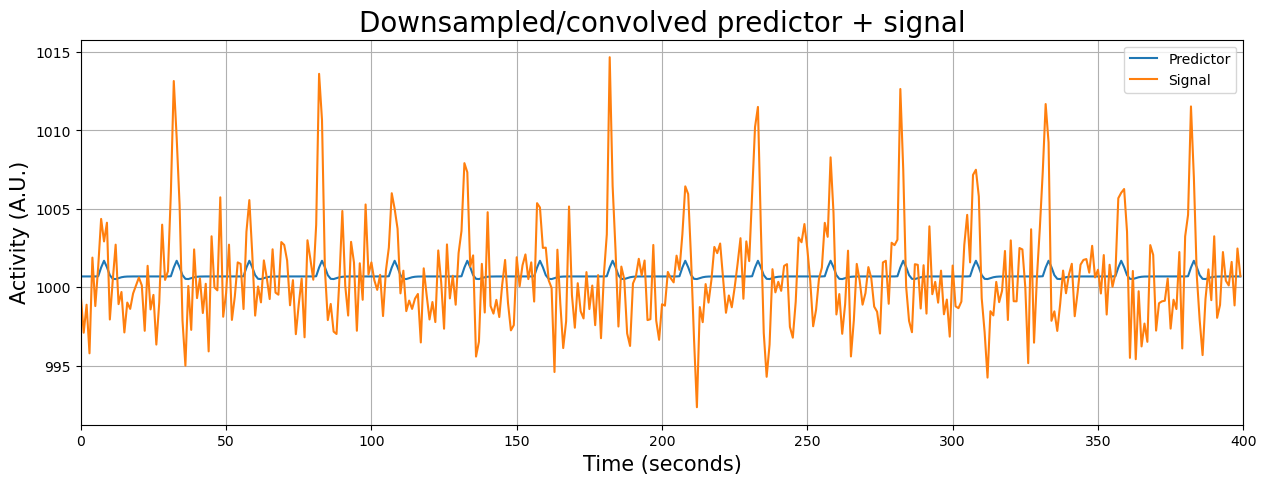

In [61]:
original_scale = np.arange(0, 800)
resampler = interp1d(original_scale, np.squeeze(predictor_conv))

desired_scale = np.arange(0, 800, 2)
predictor_conv_ds = resampler(desired_scale)

plt.figure(figsize=(15, 5))
plt.plot(predictor_conv_ds + voxel_signal.mean())
plt.plot(voxel_signal)
plt.grid()
plt.title('Downsampled/convolved predictor + signal', fontsize=20)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.xlabel('Time (seconds)', fontsize=15)
plt.legend(['Predictor', 'Signal'])
plt.xlim(x_lim)
plt.show()

#### Initial upsampling of predictors
In the previous examples, the resampling process came down to selecting every other datapoint (at $t=0$, $t=2$, $t=4$, ..., $t=798$), because our onsets were all "locked" to "round" seconds (e.g., $t=10$, $t=60$, but never $t=10.29$ or something). Very often, however, stimuli (or whatever you're using to construct your predictors) are not locked to "round" seconds. How would you then initially create a predictor? One way is to do so is to create your stimulus predictor on a more precise timescale, such as on hundredths of seconds (i.e., with a precision of 0.01 seconds). In other words, we oversample the predictor with a factor 100. Then, we can set the indices in this oversampled predictor to our onsets with a higher precision (e.g., for a particular onset at 5.12 seconds, we can set the predictor at index 512 to 1).

Let's do this below for some hypothetical onsets logged with millisecond precision for an experiment lasting 50 seconds:

In [62]:
onsets2 = np.array([3.62, 16.26, 34.12, 42.98])  # in seconds
duration = 50  # duration experiment in seconds
osf = 100  # osf = OverSampling Factor

pred2 = np.zeros(duration * osf)
print("Size of oversampled (factor: 1000) predictor: %i" % pred2.size)

onsets2_in_msec = (onsets2 * osf).astype(int)  # we convert it to int, because floats (even when it's 5.0) cannot be used as indices
pred2[onsets2_in_msec] = 1

Size of oversampled (factor: 1000) predictor: 5000


Now, to convolve this signal, we should also define our HRF with a higher temporal precision (i.e., hundredths of seconds). Notice that the HRF is also a lot smoother when defined it on a timescale of seconds.

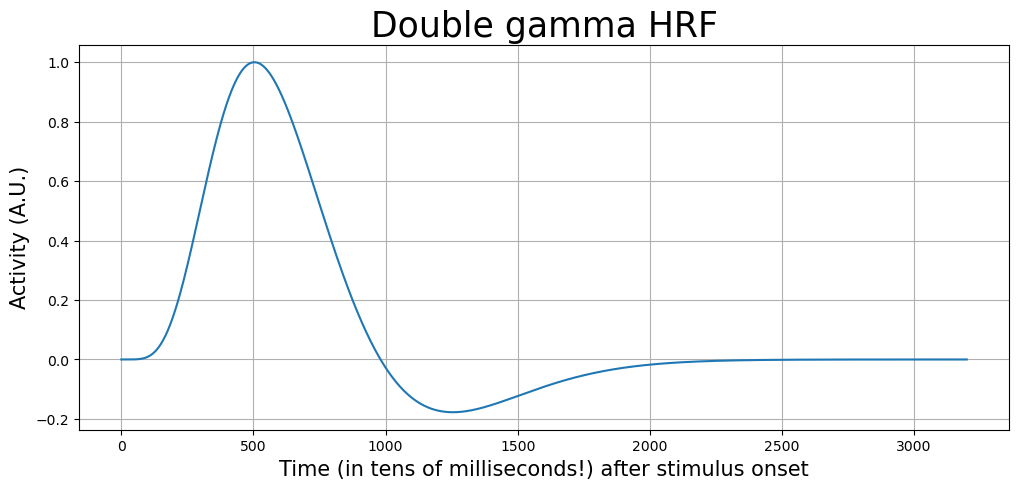

In [63]:
osf = 100 * TR
hrf_ms = glover_hrf(tr=TR, oversampling=osf, time_length=32)
hrf_ms /= hrf_ms.max()  # scale such that max = 1

t = np.arange(0, hrf_ms.size)

plt.figure(figsize=(12, 5))
plt.plot(t, hrf_ms)
plt.xlabel('Time (in tens of milliseconds!) after stimulus onset', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.title('Double gamma HRF', fontsize=25)
plt.grid()
plt.show()

Now, let's convolve our predictor with the HRF again:

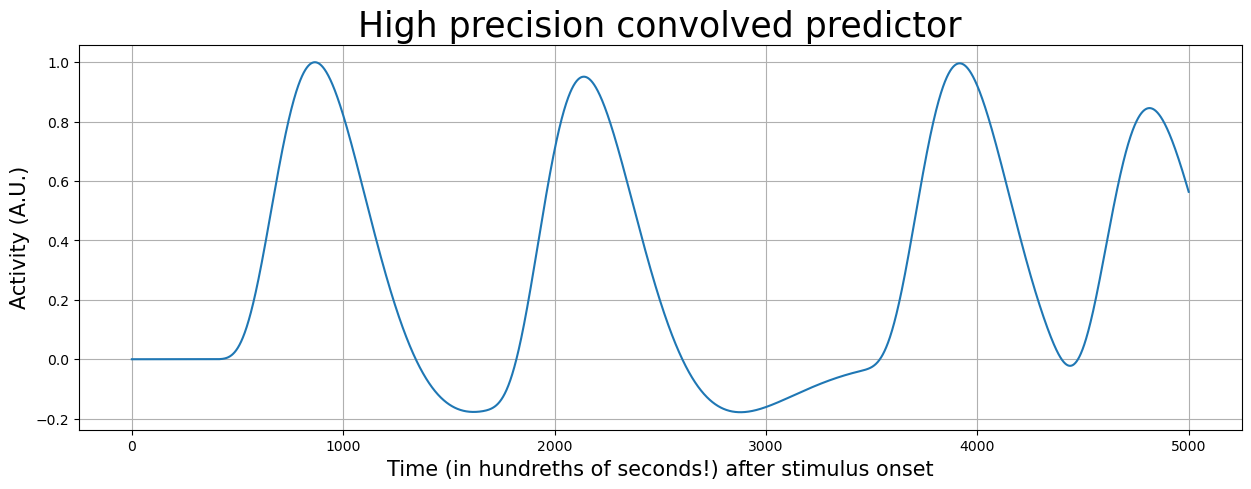

In [64]:
pred2_conv = np.convolve(pred2, hrf_ms)[:pred2.size]

plt.figure(figsize=(15, 5))
plt.plot(pred2_conv)
plt.xlabel('Time (in hundreths of seconds!) after stimulus onset', fontsize=15)
plt.ylabel('Activity (A.U.)', fontsize=15)
plt.title('High precision convolved predictor', fontsize=25)
plt.grid()
plt.show()

Now the only thing that we have to do is to downsample the convolved predictor!

<div class='alert alert-warning'>
    <b>ToDo</b> (1 point): Assuming that the described experiment had a TR of 1.25 seconds and 40 volumes, downsample the convolved predictor (<tt>pred2_conv</tt>) to the timescale of the hypothetical signal (i.e., resample the predictor to the timepoints $t=0, t=1.25, t=2.5, ... , t=48.75$). Call this downsampled predictor <tt>pred2_conv_ds</tt>.

Tip: think about the original scale (msec) and the desired scale (steps of 1.25 sec) of your predictor.
</div>

In [65]:
# Implement your ToDo here
original_scale = np.arange(0, duration, 0.01)  # in steps of 0.01 seconds, i.e., hundredths of seconds

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [66]:
''' Tests the above ToDo '''
from niedu.tests.nii.week_2 import test_pred_conv_ds

try:
    assert(pred2_conv_ds.size == 40)
except AssertionError as e:
    print("Downsampled predictor is not the right size!")
    raise(e)

test_pred_conv_ds(pred2_conv_ds, pred2_conv, original_scale)
print("Well done!")

NameError: name 'pred2_conv_ds' is not defined

#### Fitting an HRF-informed model
Finally ... we're ready to see whether the HRF-based predictor *actually* models our original voxel signal (`voxel_signal`, from earlier in the tutorial) more accurately! Let's create a proper design-matrix ($X$) by stacking an intercept with the stimulus-regressor, perform the regression analysis, and check out the results (by plotting the predicted signal against the true signal). For comparison, we'll also plot the original (unconvolved) model as well!

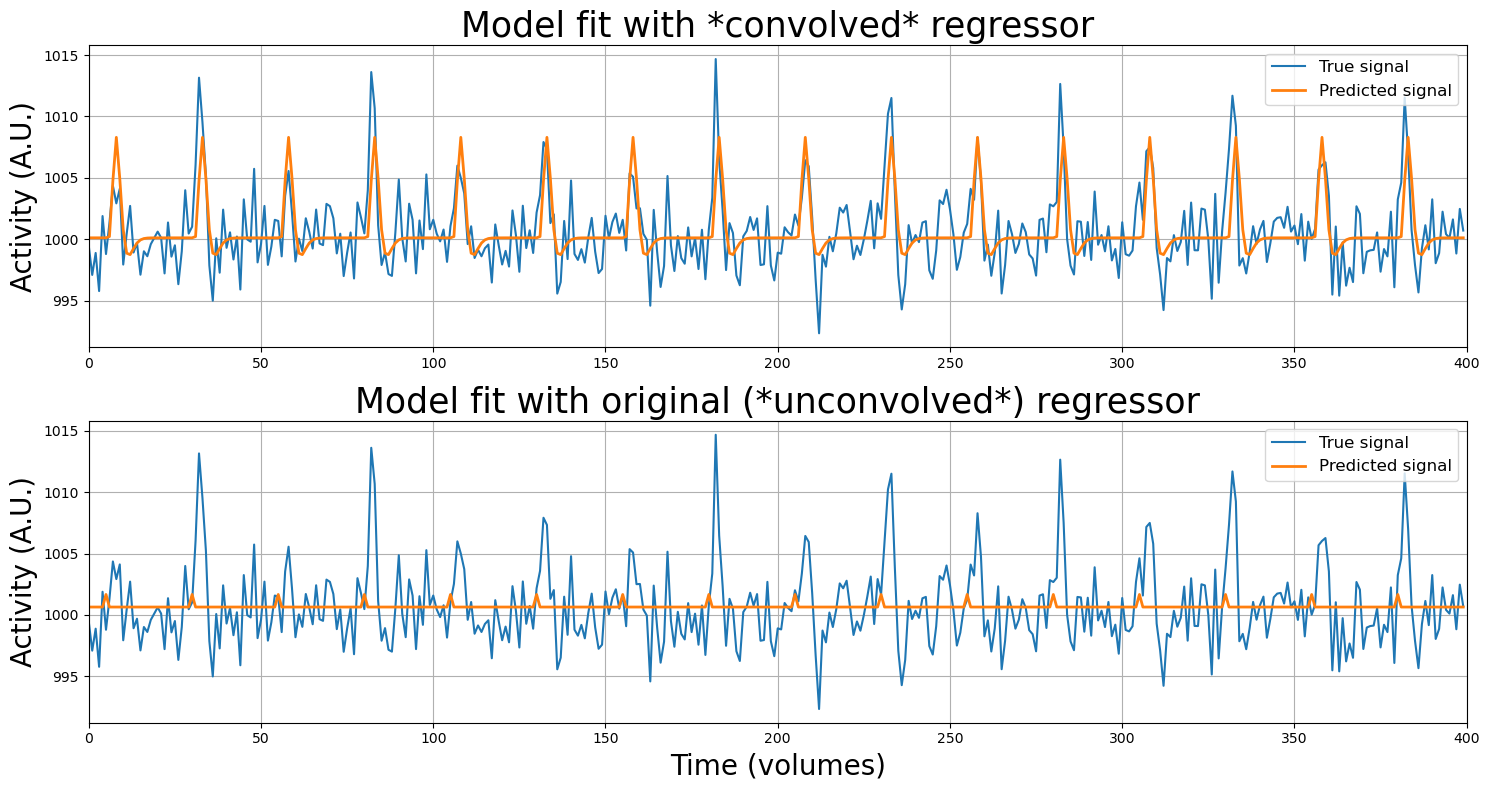

In [67]:
if predictor_conv_ds.ndim == 1:
    # Add back a singleton axis (which was removed before downsampling)
    # otherwise stacking will give an error
    predictor_conv_ds = predictor_conv_ds[:, np.newaxis]

intercept = np.ones((predictor_conv_ds.size, 1))
X_conv = np.hstack((intercept, predictor_conv_ds))
betas_conv = inv(X_conv.T @ X_conv) @ X_conv.T @ voxel_signal

plt.figure(figsize=(15, 8))

plt.subplot(2, 1, 1)
plt.plot(voxel_signal)
plt.plot(X_conv @ betas_conv, lw=2)
plt.xlim(x_lim)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with *convolved* regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(voxel_signal)
betas_simple = np.array([1000.64701684, 1.02307437])
plt.plot(X_simple @ betas_simple, lw=2)
plt.xlim(x_lim)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.title("Model fit with original (*unconvolved*) regressor", fontsize=25)
plt.legend(['True signal', 'Predicted signal'], fontsize=12, loc='upper right')
plt.xlabel("Time (volumes)", fontsize=20)
plt.grid()

plt.tight_layout()
plt.show()

Wow, that looks much better! First, let's inspect the beta-parameters:

In [68]:
print('The beta-parameter of our stimulus-predictor is now: %.3f' % betas_conv[1])
print('... which is %.3f times larger than the beta of our original '
      'beta (based on the unconvolved predictors)!' % (betas_conv[1] / betas_simple[1]))

The beta-parameter of our stimulus-predictor is now: 8.181
... which is 7.997 times larger than the beta of our original beta (based on the unconvolved predictors)!


Like we did before, we'll zoom in and show you how the estimated beta-parameters relate tho the data:

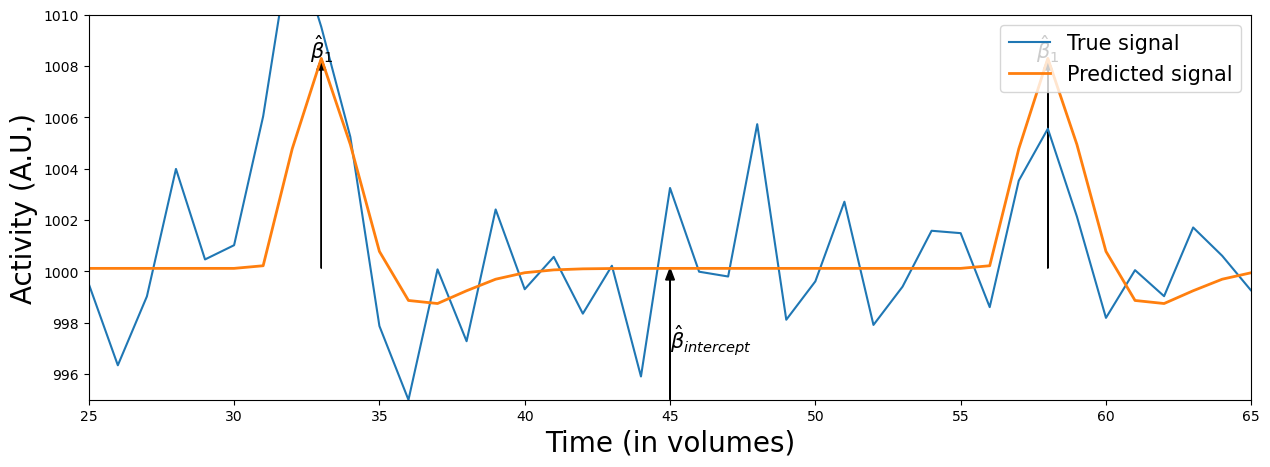

In [69]:
plot_signal_and_predicted_signal_zoom(voxel_signal, predictor_conv_ds, x_lim=(25, 65), y_lim=(995, 1010))

Alright, so we seem to measure a way larger effect of our stimulus on the voxel activity, but is the model fit actually also better? Let's find out.

In [70]:
from numpy.linalg import lstsq  # numpy implementation of OLS, because we're lazy

y_hat_conv = X_conv @ betas_conv
y_hat_orig = X_simple @ lstsq(X_simple, voxel_signal, rcond=None)[0]

MSE_conv = ((y_hat_conv - voxel_signal) ** 2).mean()
MSE_orig = ((y_hat_orig - voxel_signal) ** 2).mean()

print("MSE of model with convolution is %.3f while the MSE of the model without convolution is %.3f." %
     (MSE_conv, MSE_orig))

R2_conv = 1 - (np.sum((voxel_signal - y_hat_conv) ** 2) / np.sum((voxel_signal - voxel_signal.mean()) ** 2))
R2_orig = 1 - (np.sum((voxel_signal - y_hat_orig) ** 2) / np.sum((voxel_signal - voxel_signal.mean()) ** 2))

print("R-squared of model with convolution is %.5f and without convolution it is %.5f." % 
     (R2_conv, R2_orig))

MSE of model with convolution is 6.022 while the MSE of the model without convolution is 10.327.
R-squared of model with convolution is 0.41919 and without convolution it is 0.00388.


From the model fit metrics above, we can safely conclude that (at least for this voxel), a design ($X$) in which we include information about the expected lag/shape of the HRF is *way* better than a 'HRF-naive' design (i.e. an unconvolved design). 

<div class='alert alert-warning'>
<b>ToDo</b> (2 points):
    
So far, our examples were based on the stimulus-onsets of the two conditions (circles and squares) lumped together. This tested the hypothesis of our voxel responded to *any kind* of stimulus -- regardless of the condition (squares/circles) of the stimulus. Usually, however, you want to estimate the betas for each condition separately (i.e., how much each condition on average activates a voxel) and test the influence of each condition on the voxel separately (but estimated in the same model)! This is what you're going to do in this ToDo.

We provide you with the predictors for circles (<tt>predictor_circles</tt>) and for squares (<tt>predictor_squares</tt>) below. You have to do the following:

- convolve each predictor with the double-gamma HRF (use <tt>canonical_hrf</tt>) separately (don't forget to squeeze, trim, and add the axis back)
- downsample the convolved predictors
- stack an intercept and the two predictors **in a single design-matrix** ($X$) -- use <tt>np.hstack((intercept, pred1, pred2))</tt> for this
- calculate the beta-parameters (estimated in a single model!)
- calculate MSE (store this in the variable <tt>mse_new</tt>) and $R^2$ (store this in the variable <tt>r2_new</tt>)
</div>

In [71]:
predictor_circles = np.zeros((800, 1))
predictor_circles[onsets_circles] = 1

predictor_squares = np.zeros((800, 1))
predictor_squares[onsets_squares] = 1

# Implement your solution below

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [72]:
''' Tests the ToDo above (but only if the variables are named correctly). '''
from niedu.tests.nii.week_2 import test_mse_and_r2_new

if 'mse_new' not in dir():
    raise ValueError("Could not find the variable 'mse_new'! Did you spell it correctly?")

if 'r2_new' not in dir():
    raise ValueError("Could not find the variable 'r2_new'! Did you spell it correctly?")

test_mse_and_r2_new(predictor_circles, predictor_squares, canonical_hrf, voxel_signal, mse_new, r2_new)
print("Well done!")

ValueError: Could not find the variable 'mse_new'! Did you spell it correctly?

<div class='alert alert-info'>
<b>ToThink</b> (1 point): If you've done the above ToDo correctly, you should have found that the model fit of the design-matrix with the circles and squares predictors separately (as you did in the ToDo) leads to a (somewhat) better model fit (lower MSE/higher $R^2$) than the design-matrix with the conditions lumped together in a single predictor (as we did earlier).

Argue why you think this may be the case here.
</div>

YOUR ANSWER HERE

#### Temporal basis functions
Most studies use a canonical HRF to convolve with their predictors. However, remember that using a canonical HRF assumes that the particular shape of that HRF will be appropriate for each voxel, each condition, and each subject in your study. This is quite a strong assumption. In fact, studies have shown that the exact shape of the HRF often differs between voxels, conditions, and subjects (as is explained in detail by the [video on basis sets](https://www.youtube.com/watch?v=YfeMIcDWwko&index=21&list=PLcvMDPDk-dSmTBejANv7kY2mFo1ni_gkA) by Tor Wager).

In fact, this might also be the case in our data! If you've done the ToDo correctly, you might have seen that the predictions ($\hat{y}$) seem to "peak" too late for the circle-stimuli ... In fact, let's plot the data ($y$) and the prediction (based on the previously defined stimulus predictor, i.e., the circles and squares in a single predictor):

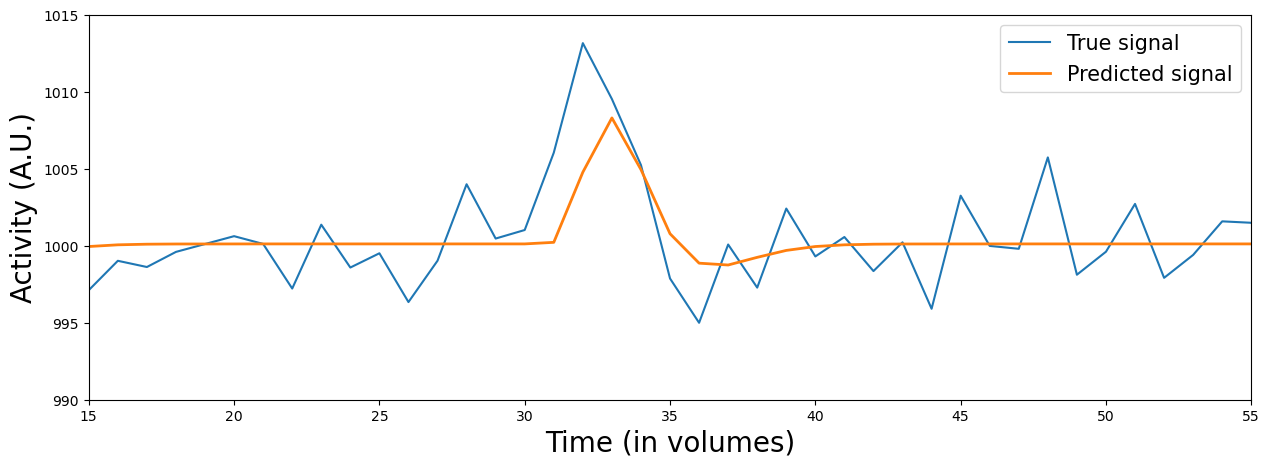

In [73]:
plot_signal_and_predicted_signal_zoom(voxel_signal, X_conv, x_lim=(15, 55), y_lim=(990, 1015), plot_params=False)

So, what should be do about this? Well, one solution is to use *temporal basis functions* (also called *temporal basis sets*). Temporal basis functions model the HRF as *a combination of (hemodynamic response) functions*. 

In practice, this amounts to convolving your predictor with not one, but multiple HRFs. This results in multiple predictors per stimulus-condition! Each HRF measures a "part" (or property) of the total HRF. Together, these predictors aim to estimate the complete HRF for a given stimulus-vector (condition). 

We're going to use *double-gamma basis functions* as an example of a temporal basis set (but there are other sets, like the (*single-gamme basis set*, *sine basis set* and *finite impulse response* set). In this particular basis set, the original double-gamma HRF is used in combination with its first derivative (often called the 'temporal derivative'). (Sometimes, the second derivative, also called the "dispersion derivative", is also added. We leave this out for simplicity here.)

Suppose we have only one stimulus condition. Then, the signal ($\mathbf{y}$) is not modelled by only one convolved predictor ($X_{\mathrm{stim}}$) but by two predictors: a predictor convolved with the original HRF ($X_{\mathrm{orig}}$) and a predictor convolved with the temporal derivative of the HRF ($X_{\mathrm{temp}}$). Formally:

\begin{align}
y = \beta_{0} + \mathbf{X}_{\mathrm{orig}}\beta_{1} + \mathbf{X}_{\mathrm{temp}}\beta_{2} + \epsilon
\end{align}

Alright, but how do we compute this temporal derivative and what does this look like? Again, we can use a function from the [nilearn](https://nilearn.github.io) package: `glover_time_derivative`:

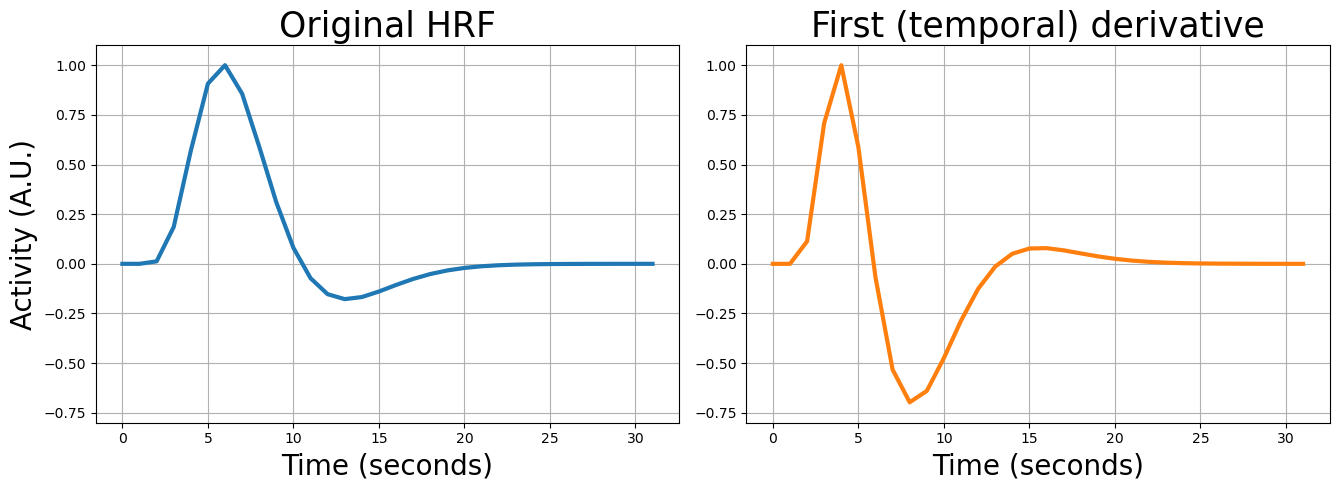

In [74]:
from nilearn.glm.first_level.hemodynamic_models import glover_time_derivative

tderiv_hrf = glover_time_derivative(tr=2, oversampling=2)
tderiv_hrf /= tderiv_hrf.max()

plt.figure(figsize=(20, 5))
plt.subplot(1, 3, 1)
plt.plot(canonical_hrf, lw=3)
plt.ylim(-0.8, 1.1)
plt.ylabel("Activity (A.U.)", fontsize=20)
plt.xlabel("Time (seconds)", fontsize=20)
plt.title("Original HRF", fontsize=25)
plt.grid()

plt.subplot(1, 3, 2)
plt.plot(tderiv_hrf, c='tab:orange', lw=3)
plt.ylim(-0.8, 1.1)
plt.xlabel("Time (seconds)", fontsize=20)
plt.title("First (temporal) derivative", fontsize=25)

plt.tight_layout()
plt.grid()

plt.show()

The cool thing about this double-gamma basis set is that the derivatives can (to a certain extent) correct for slight deviations in the lag and shape of the HRF based on the data! Specifically, the first (temporal) derivative can correct for slight differences in lag (compared to the canonical single-gamma HRF) and the second (dispersion) derivative can correct for slight difference in the width (or "dispersion") of the HRF (compared to the canonical single-gamma HRF). 

"How does this 'correction' work, then?", you might ask. Well, think about it this way: the original (canonical) HRF measures the increase/decrease &mdash; or amplitude &mdash; of the BOLD-response. In a similar way, the temporal derivative measures the *onset* &mdash; or lag &mdash; of the BOLD-response. (And if you use the dispersion derivative: this would measure the *width* of the BOLD-response.) 

When we use our two predictors (one convolved with the canonical HRF, one with the temporal derivative) in a linear regression model, the model will assign each predictor (each part of the HRF) a beta-weight, as you know. These beta-weights are chosen such that model the data &mdash; some response of the voxel to a stimulus &mdash; as well as possible. Basically, assigning a (relatively) high (positive or negative) beta-weight to the predictor convolved with the temporal derivative will "shift" the HRF (increases/decreases the onset of the HRF).

Alright, let's visualize this. Suppose we have a voxel that we know does not conform to the specific assumptions about lag (onset) of the canonical (double-gamma) HRF. Specifically, we see that the canonical HRF peaks too early.
We'll show below that it suboptimally explains this voxel:

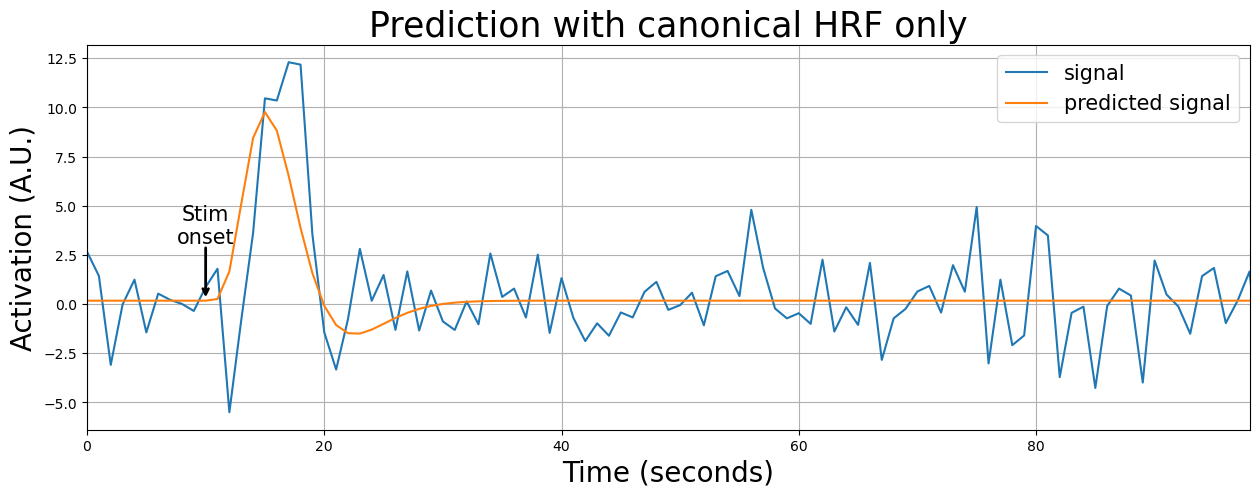

In [75]:
from niedu.utils.nii import simulate_signal

# tbs = temporal basis set
y_tbs, X_tbs = simulate_signal(
    onsets=[10],
    conditions=['stim'],
    duration=100,
    TR=1,
    icept=0,
    params_canon=[10],
    params_deriv1=[-8],
    std_noise=2,
    rnd_seed=10,
    plot=False
)

X_canon_only = X_tbs[:, :-1]  # remove temporal derivative for now

# Do regression 
beta_canon = inv(X_canon_only.T @ X_canon_only) @ X_canon_only.T @ y_tbs
yhat_canon = X_canon_only @ beta_canon

# Plot the data and the prediction (y_hat)
plt.figure(figsize=(15, 5))
plt.plot(y_tbs)
plt.plot(yhat_canon)
plt.xlim(0, 98)
plt.xlabel("Time (seconds)", fontsize=20)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.annotate('', xy=(10, 3), xytext=(10, 0.2),
             arrowprops=dict(arrowstyle='<-', lw=2))
plt.text(10, 3.1, 'Stim\nonset', horizontalalignment='center', fontsize=15)
plt.legend(['signal', 'predicted signal'], fontsize=15)
plt.title("Prediction with canonical HRF only", fontsize=25)
plt.grid()
plt.show()

As you can see, the predicted signal (orange line) misses the peak of the BOLD-response. Now, let's see what happens if we add the temporal derivative to the model:

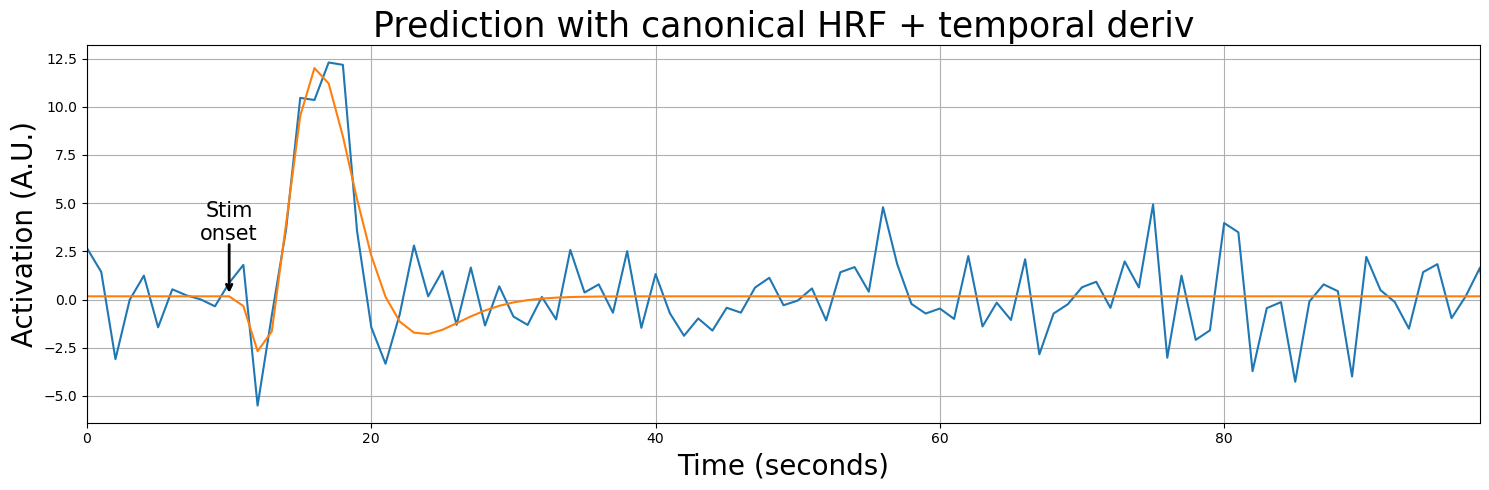

In [76]:
# Do regression with HRF + temp deriv HRF
beta_td = inv(X_tbs.T @ X_tbs) @ X_tbs.T @ y_tbs
yhat_td = X_tbs @ beta_td

# Plot model with temp deriv HRF
plt.figure(figsize=(15, 5))
plt.plot(y_tbs)
plt.plot(yhat_td)
plt.xlim(0, 98)
plt.ylabel("Activation (A.U.)", fontsize=20)
plt.annotate('', xy=(10, 3), xytext=(10, 0.2),
             arrowprops=dict(arrowstyle='<-', lw=2))
plt.text(10, 3.1, 'Stim\nonset', horizontalalignment='center', fontsize=15)
plt.title("Prediction with canonical HRF + temporal deriv", fontsize=25)
plt.xlabel("Time (seconds)", fontsize=20)

plt.grid()

plt.tight_layout()
plt.show()

As you can see, the prediction improves quite a bit when including the temporal derivative! But how should we interpret the beta-parameters? Well, usually people don't really interpret the temporal (and dispersion derivative) HRFs (unless they're interested in lag/width of the HRF), because most researchers are interested in the activation/deactivation (the amplitude) of voxels in response to a stimulus, which corresponds to the beta-parameters associated with the canonical HRF. So, basically, the temporal (and dispersion) derivative(s) are only used to "correct" for deviations in terms of lag/shape from the canonical HRF!

So, should you then always use a (gamma) basis set? People are quite divided on the topic of whether to use basis sets or a canonical HRF. In our experience, derivatives (e.g. in the gamma basis sets) offer little improvement over a canonical HRF in simple group-level analyses (in which you average over many participants; the topic of week 5/6!), but it doesn't hurt either (given that you have "enough" degrees of freedom).

<div class='alert alert-warning'>
    <b>ToDo</b> (optional; 0 points): For gamma-based basis sets, the different components correlate with each other (especially the canonical HRF and its dispersion derivative). As such, these two predictors will "compete" for explained variance, which affects their parameter estimates and associated statistics. Because people are often only interested in the amplitude component of our basis set, they sometimes "orthogonalize" the HRF derivatives with respect to the canonical HRF predictor. Orthogonalization is a process in which a predictor is "decorrelated" from another (set of) predictors(s) (for more details on orthogonalization, see <a href="https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0126255">this excellent article</a>). Orthogonalization amounts to regressing out the to-be-orthogalized predictor from the other predictor(s).

In this ToDo, try orthogonalizing the canonical HRF predictor with respect to its temporal derivative. Using the variable <tt>Xc</tt> below (which contains just two predictors: the canonical HRF predictor and the temporal derivative predictor). Make sure to <em>replace</em> the temporal derivative predictor (i.e., second column) with the predictor with the variance related to the canonical HRF removed).
</div>

In [77]:
''' Implement your ToDo here. '''
# First column: canonical HRF predictor, second column: temp. deriv predictor
Xc = X_tbs[:, 1:].copy()
# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [78]:
''' Tests the above ToDo. '''
from niedu.tests.nii.week_2 import test_orthogonalization
test_orthogonalization(X_tbs, Xc)

AssertionError: 
Arrays are not almost equal to 6 decimals

Mismatched elements: 29 / 200 (14.5%)
Max absolute difference: 0.01935921
Max relative difference: 0.36189158
 x: array([[ 0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00],...
 y: array([[ 0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00],
       [ 0.000000e+00,  0.000000e+00],...

<div class='alert alert-warning'>
<b>ToDo</b> (5 points):
    
Reanalyze the voxel signal with the separate conditions (like the last ToDo), but this time with a both the canonical HRF (<tt>canonical_hrf</tt>) and the associated temporal derivative (you can use the variable <tt>tderiv_hrf</tt>)! Calculate the beta-parameters for the voxel signal (i.e., the variable <tt>voxel_signal</tt>), MSE, and $R^2$. Store the MSE in a variable named <tt>mse_gbf</tt> and $R^2$ in a variable named <tt>r2_gbf</tt>. 

Please implement this assignment in "steps", such that we can test intermediate output:
1. Convolve the circle predictor (<tt>predictor_circles</tt>) and the squares predictor (<tt>predictor_squares</tt>) with the two HRF basis functions (canonical, temporal deriv.) separately, giving you 4 predictors, stack them together and add an intercept (make sure the intercept is the first column). Then, downsample your design matrix to the scale of you voxel signal. Store your downsampled design matrix in a variable named <tt>X_gbf</tt>; Note: the order of the columns should be: intercept, circles (canonical), circles (temp. deriv.), squares (canonical), squares (temp. deriv.). If you don't do this, automatic grading will fail and you won't get any points; (2 points)
2. Run linear regression (your DV is the variable <tt>voxel_signal</tt>) and store your betas in a variable named <tt>betas_gbf</tt>; (1 point)
3. Calculate R-squared and store it in a variable named <tt>r2_gbf</tt>; (1 point)
4. Calculate MSE and store it in a variable named <tt>mse_gbf</tt>; (1 point)

Some tips:
- you can use the definitions of the HRFs from earlier (<tt>canonical_hrf</tt> and <tt>tderiv_hrf</tt>)
- make sure that your design-matrix has, eventually, 5 columns (intercept + 2 predictors x 2 conditions)
- don't forget to downsample your design matrix
</div>

In [79]:
# Step 1: convolve the predictors (don't forget to trim and downsample)!
# Hint: print the shape of your predictors after convolving, trimming, and downsampling - 
# does this shape correspond to the number of datapoints of the experiment?

# We have created the binary predictors for you already
predictor_circles = np.zeros(800)
predictor_circles[onsets_circles] = 1

predictor_squares = np.zeros(800)
predictor_squares[onsets_squares] = 1

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [80]:
''' Tests the above ToDo. '''

if 'X_gbf' not in dir():
    msg = "Could not find the variable 'X_gbf'; did you name it correctly?"
    raise ValueError(msg)

try:
    np.testing.assert_array_equal(X_gbf[:, 0], np.ones(X_gbf.shape[0]))
except AssertionError as e:
    print("First column is not an intercept (vector of ones)!")
    raise(e)

if X_gbf.shape[0] != 400:
    msg = 'You probably forgot to trim and/or downsample ...'
    raise ValueError(msg)

from niedu.tests.nii.week_2 import test_canon_and_tderiv_design
test_canon_and_tderiv_design(predictor_circles, predictor_squares, canonical_hrf, tderiv_hrf, X_gbf)

ValueError: Could not find the variable 'X_gbf'; did you name it correctly?

In [81]:
# Step 2: run linear regression

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [82]:
''' Tests the above steps. '''
from niedu.tests.nii.week_2 import test_canon_and_tderiv_glm
test_canon_and_tderiv_glm(X_gbf, voxel_signal, betas_gbf)

NameError: name 'X_gbf' is not defined

In [83]:
# Step 3: calculate R-squared (and store it in a variable named r2_gbf)

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [84]:
''' Tests the above ToDo. '''
from niedu.tests.nii.week_2 import test_canon_and_tderiv_r2
test_canon_and_tderiv_r2(X_gbf, betas_gbf, voxel_signal, r2_gbf)

NameError: name 'X_gbf' is not defined

In [85]:
# Step 4: calculate MSE (and store it in a variable named mse_gbf)

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [86]:
''' Tests the above ToDo. '''
from niedu.tests.nii.week_2 import test_canon_and_tderiv_mse
test_canon_and_tderiv_mse(X_gbf, betas_gbf, voxel_signal, mse_gbf)

NameError: name 'X_gbf' is not defined

From what we've showed so far, hopefully, you noticed that how linear regression is applied to model a voxel signal is not that much different from 'regular' data, except for the convolution/HRF part. At this moment, you already know 95% of how univariate analysis works! There are, however, still a couple of concepts we need to address, which we'll do next week: statistical inference of model parameters.

<div class='alert alert-warning'>
<b>ToDo</b> (3 points)

For the last ToDo, let's do a short "puzzle". Below, we'll load a function, called <tt>black_box</tt>, that implements a linear regression model with the following functional form:

\begin{align}
y = \beta_{0} + x_{1}\beta_{1} + x_{2}\beta_{2} + x_{3}\beta_{3}  
\end{align}

As you can see, it has four parameters (no error term!): $\beta_{0}$ represents the intercept here and $\beta_{1}$ up to $\beta_{4}$ represent the parameters of the model's single predictors ($x_{1}$ up to $x_{3}$). The function <tt>black_box</tt> takes three inputs: <tt>x1</tt>, <tt>x2</tt>, and <tt>x3</tt>. The function outputs a (deterministic) value for $y$. So, you could use ("query") the function like this:

<tt>y_output = black_box(x1=10, x2=5, x3=2)</tt>
    
Now, your assignment is to, experimentally, figure out ("reverse engineer") the model's parameters $\beta_{0}$, $\beta_{1}$, $\beta_{2}$, and $\beta_{3}$. In other words, run the function with some inputs values and check the corresponding outputs. From those combinations of inputs and outputs, you can reconstruct the four different parameters. Once you figure out these betas, store them in the variables <tt>beta_0</tt>, <tt>beta_1</tt>, <tt>beta_2</tt>, and <tt>beta_3</tt>.

Also, explain &mdash; concisely &mdash; how you figured out the answer in the text cell below the test-cell.
</div>

In [87]:
from niedu.tests.nii.week_2 import black_box
# Implement your todo here!

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [88]:
''' Tests the above ToDo. '''
for b in ['0', '1', '2', '3']:
    
    if not 'beta_%s' % b in dir():
        raise ValueError("You didn't define the variable beta_%s." % b)

from niedu.tests.nii.week_2 import test_black_box
test_black_box(beta_0, beta_1, beta_2, beta_3)

ValueError: You didn't define the variable beta_0.

YOUR ANSWER HERE

<div class='alert alert-success'>
    <b>Tip!</b>
    Before handing in your notebooks, we recommend restarting your kernel (<em>Kernel</em> &rarr; <em>Restart & Clear Ouput</em>) and running all your cells again (manually, or by <em>Cell</em> &rarr; <em>Run all</em>). By running all your cells one by one (from "top" to "bottom" of the notebook), you may spot potential errors that are caused by accidentally overwriting your variables or running your cells out of order (e.g., defining the variable 'x' in cell 28 which you then use in cell 15).
</div>